# P4 Scoring Model

## Import des librairies

In [94]:
import seaborn as sns
import pandas as pd 
import os
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from IPython.display import display, HTML

# numpy and pandas for data manipulation

pd.set_option('display.max_row', 140)
pd.set_option('display.max_column', 122)


In [95]:
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("seaborn version:", sns.__version__)

pandas version: 2.2.3
numpy version: 2.1.1
seaborn version: 0.13.2


In [96]:
def display_info(title = "",tag="h2",pTag="p",message="Params allowed: title,tag,message,color", fontsize="" , color="white"):
    if (title!=""):
        display(HTML(f"""<{tag} style='color:{color};font-size:{fontsize}'>{title}</{tag}>"""))
    else:
        display(HTML(f"""
        <{pTag} style='color:{color}; font-size:{fontsize}'>{message}</{pTag}>"""))

## Importation des données

Les données sont réparties dans les fichiers ci-dessous:

In [97]:
display_info(message="Voici la liste des différents fichiers disponibles :",color="green")
print(os.listdir("../datas"))

['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


et lié selon le graphique suivant:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

**application_{train|test}.csv** <br>
Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

**bureau.csv**<br>
Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

**bureau_balance.csv**<br>
Soldes mensuels des crédits antérieurs au bureau de crédit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a (nombre de prêts dans l'échantillon * nombre de crédits précédents relatifs * nombre de mois où nous avons un historique observable pour les crédits précédents) lignes.

**POS_CASH_balance.csv**<br>
Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec Home Credit.
Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (nombre de prêts dans l'échantillon * nombre de crédits précédents relatifs * nombre de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

**credit_card_balance.csv**<br>
Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (nombre de prêts dans l'échantillon * nombre de cartes de crédit précédentes relatives * nombre de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

**previous_application.csv**<br>
Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon.
Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

**installments_payments.csv**<br>
Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon.
Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit immobilier lié aux prêts de notre échantillon.

**HomeCredit_columns_description.csv**<br>
Ce fichier contient les descriptions des colonnes des différents fichiers de données.


In [50]:
app_train = pd.read_csv('../datas/application_train.csv')
app_test = pd.read_csv('../datas/application_test.csv')
bureau = pd.read_csv('../datas/bureau.csv')
bureau_balance = pd.read_csv('../datas/bureau_balance.csv')
pos_CASH_balance = pd.read_csv('../datas/POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('../datas/credit_card_balance.csv')
previous_application = pd.read_csv('../datas/previous_application.csv')
installments_payments = pd.read_csv('../datas/installments_payments.csv')
columns_description = pd.read_csv('../datas/HomeCredit_columns_description.csv', sep=';', encoding="unicode_escape")

In [51]:
# Liste des datasets et titres
datasets = [app_train,app_test, bureau, bureau_balance, pos_CASH_balance, credit_card_balance,
            previous_application, installments_payments, columns_description]

titles = ["app_train","app_test", "bureau", "bureau_balance", "pos_CASH_balance", "credit_card_balance",
          "previous_application", "installments_payments", "columns_description"]

# Création du DataFrame avec les infos
info_df = pd.DataFrame({},)
info_df['Dataset'] = titles

info_df["nbrs_of_columns"] = [len(df.columns) for df in datasets]

# Remplacement des virgules par des sauts de ligne
info_df["columns_name"] = [', '.join(list(df.columns)) for df in datasets]

info_df['nbrs_of_rows'] = [len(df) for df in datasets]

info_df.style.background_gradient(cmap='rocket')


In [132]:
display_info(title="1 &nbsp Exploratory Data Analysis (EDA)", fontsize="30px", color="yellow")
display_info(title="Analyse Univarié", fontsize="28px", color="red")
display_info(title="Analyse de la forme de notre dataset", fontsize="26px", color="green")
display_info(pTag="ul", message="""<li>Identification de la target de notre dataset 'application_train' : TARGET</li></br>
             <li>Nombre de lignes et colonnes : 252137 lignes et 122 colonnes</li></br>
             <li>Type de variables :</br></br>
             <ul>
             <li>float64: 65,</li>
             <li>int64: 41</li>
             <li>object: 16</li>
             </ul></br>
             <li>Identification des valeurs manquantes :</br></br>
             <ul>
             <li>Nombre de colonnes > 60% de NaN (17) </li></br>
             <li>Beaucoup des colonnes avec le plus grand % de valeurs manquant concerne le logement des clients</li></br>
             <li>Ext_SOURCE_1 qui est un score normalisé venant d'une source de données externe a 51.9% de valeurs manquantes</li>
             <li>Ext_SOURCE_2 qui est un score normalisé venant d'une source de données externe a 0.2% de valeurs manquantes</li>
             <li>Ext_SOURCE_3 qui est un score normalisé venant d'une source de données externe a 19.8% de valeurs manquantes</li>
             </ul>
             </li>""")
display_info(title="Analyse de fond de notre dataset", fontsize="26px", color="green")
display_info(pTag="ul", message="""<li>Visualisation de la target de notre dataset 'application_train' : environ 10% de client en difficulté</li></br>
             <li>Nombre de lignes et colonnes : 252137 lignes et 122 colonnes</li></br>
             <li>Type de variables :</br></br>
             <ul>
             <li>float64: 65,</li>
             <li>int64: 41</li>
             <li>object: 16</li>
             </ul></br>
             <li>Identification des valeurs manquantes :</br></br>
             <ul>
             <li>Nombre de colonnes > 60% de NaN (17) </li></br>
             <li>Beaucoup des colonnes avec le plus grand % de valeurs manquant concerne le logement des clients</li></br>
             <li>Ext_SOURCE_1 qui est un score normalisé venant d'une source de données externe a 51.9% de valeurs manquantes</li>
             <li>Ext_SOURCE_2 qui est un score normalisé venant d'une source de données externe a 0.2% de valeurs manquantes</li>
             <li>Ext_SOURCE_3 qui est un score normalisé venant d'une source de données externe a 19.8% de valeurs manquantes</li>
             </ul>
             </li></br></br>
             <li>Variables catégorielles :</br></br>
             <ul>
             <li>Certaine variable sont binaire (Yes, No)</li>
             <li>D'autre représente la répartitions du status matrimonial ou encore le type de logement donc non binaire</li>
             </ul>
             </li></br></br>
             <li>Analyse Bi-variées TARGET / Variables :</br></br>
             <ul>
             <li>Il n'y a pas de différence de distribution notable sur nos variables</li>
             </ul>
             </li>
             """)
display_info(title="Analyse Bi-variées", fontsize="28px", color="red")
display_info(pTag="ul", message="""
             <li>TARGET / AMT :</br></br>
             <ul>
             <li>Il n'y a pas de différence de distribution notable sur nos variables</li>
             </ul>
             </li></br>
             <li>TARGET / DAYS :</br></br>
             <ul>
             <li>Les distribution semble etre identique et proportionnel au statut du client</li>
             </ul>
             </li></br>
             <li>TARGET / DAYS_BIRTH :</br></br>
             <ul>
             <li>Il n'y a pas de différence de distribution notable de notre target en fonction de l'age des clients</li>
             </ul>
             </li>
             """)

## La Cible à prédire: Le client est-il en difficulté de paiement?

In [53]:
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [54]:
# app_train=pd.merge(app_train,bureau, on='SK_ID_CURR',how='left')
# app_train=pd.merge(app_train,bureau_balance,on='SK_ID_BUREAU', how='left')

In [55]:
app_train.shape

(307511, 122)

In [56]:
app_train.dtypes

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


In [57]:
valueTypes=app_train.dtypes.value_counts()
display_info(message=f'Voici lenombres de fois ou chaque types de valeurs apparait:</br></br> {valueTypes}',fontsize="16px")

<Axes: >

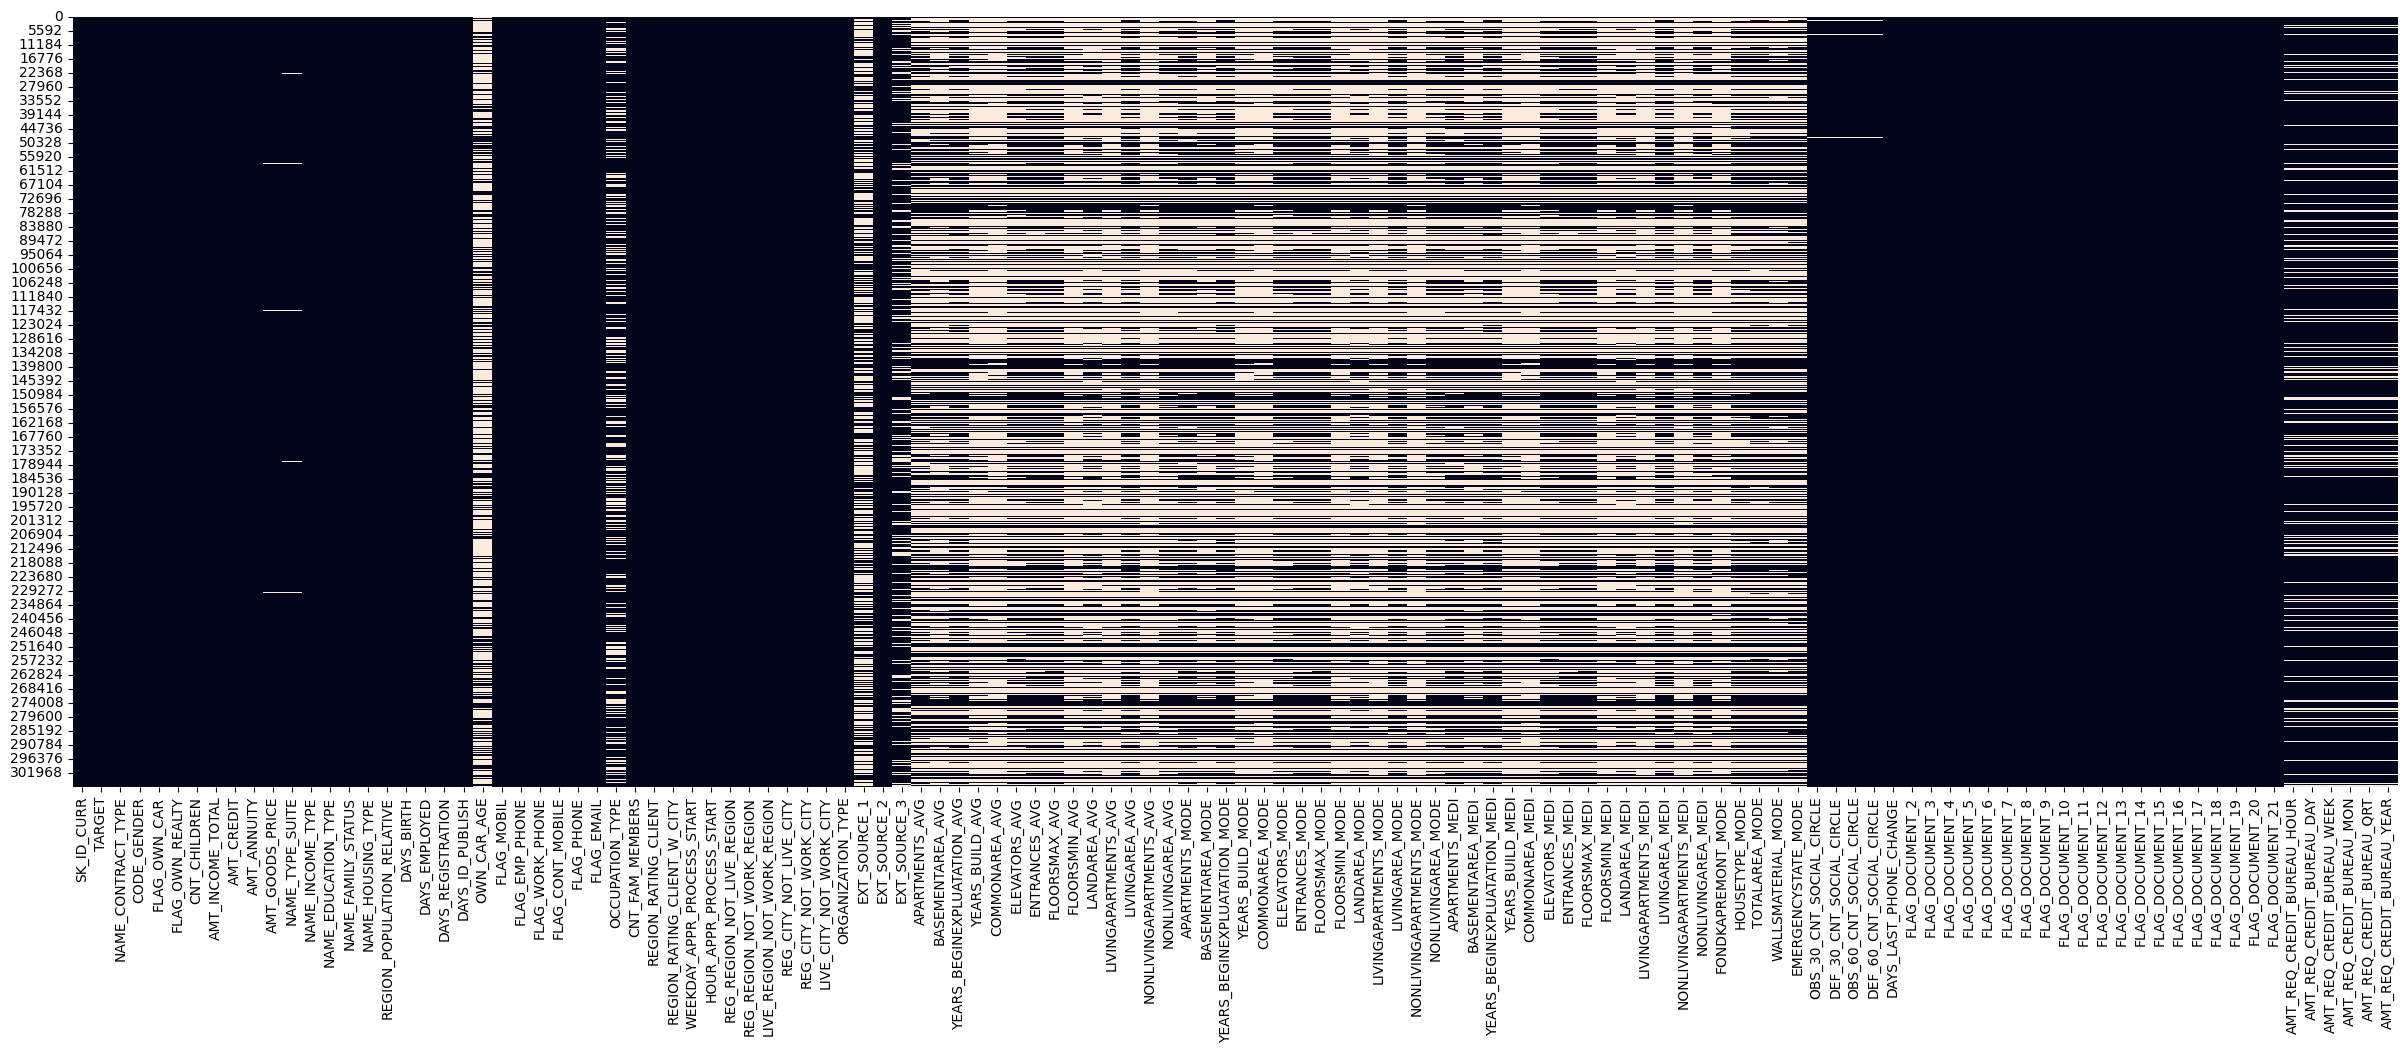

In [58]:
display_info(message=f'On représente les valeurs manquantes sous forme de heatmap',fontsize="16px")
plt.figure(figsize=(30,10))
sns.heatmap(app_train.isna(), cbar=False)

In [59]:
display_info(message="""On remarque plusieurs individus avec des ligne de différentes variables vide.</br></br>
             Cela peut nous informer sur une éventuel correlation des variables entre elles.""",fontsize="16px")

In [60]:
display_info(title="""On va représenter les valeurs manquante en pourcentage""")
display_info(message="""Pourcentage des valeurs manquantes du dataset 'application_train' :""")
((app_train.isna().sum()/app_train.shape[0])*100).sort_values(ascending=False)

COMMONAREA_MEDI                 69.872297
COMMONAREA_AVG                  69.872297
COMMONAREA_MODE                 69.872297
NONLIVINGAPARTMENTS_MODE        69.432963
NONLIVINGAPARTMENTS_AVG         69.432963
NONLIVINGAPARTMENTS_MEDI        69.432963
FONDKAPREMONT_MODE              68.386172
LIVINGAPARTMENTS_MODE           68.354953
LIVINGAPARTMENTS_AVG            68.354953
LIVINGAPARTMENTS_MEDI           68.354953
FLOORSMIN_AVG                   67.848630
FLOORSMIN_MODE                  67.848630
FLOORSMIN_MEDI                  67.848630
YEARS_BUILD_MEDI                66.497784
YEARS_BUILD_MODE                66.497784
YEARS_BUILD_AVG                 66.497784
OWN_CAR_AGE                     65.990810
LANDAREA_MEDI                   59.376738
LANDAREA_MODE                   59.376738
LANDAREA_AVG                    59.376738
BASEMENTAREA_MEDI               58.515956
BASEMENTAREA_AVG                58.515956
BASEMENTAREA_MODE               58.515956
EXT_SOURCE_1                    56

In [61]:
nanPercentage=(((app_train.isna().sum()/app_train.shape[0])*100)>60).sum()
display_info(message=f'Nombre de colonne avec 60 % de valeurs NaN : {nanPercentage} ')

In [62]:
display_info(title="""Eliminiation colonnes inutiles""", color="yellow")
display_info(message="""On peut éliminer toute les colonne qui ne nous paraisse pas pertinente</br>
             ici on garde uniquement les colonnes ayant moins de 50% de valeurs manquantes afin de conserver au minimum la variable EXT_SOURCE_1 """)

In [65]:
app_train=app_train[app_train.columns[app_train.isna().sum()/app_train.shape[0]<=0.57]]

In [66]:
((app_train.isna().sum()/app_train.shape[0])*100).sort_values(ascending=False)

EXT_SOURCE_1                    56.381073
NONLIVINGAREA_AVG               55.179164
NONLIVINGAREA_MODE              55.179164
NONLIVINGAREA_MEDI              55.179164
ELEVATORS_AVG                   53.295980
ELEVATORS_MEDI                  53.295980
ELEVATORS_MODE                  53.295980
WALLSMATERIAL_MODE              50.840783
APARTMENTS_MODE                 50.749729
APARTMENTS_MEDI                 50.749729
APARTMENTS_AVG                  50.749729
ENTRANCES_AVG                   50.348768
ENTRANCES_MEDI                  50.348768
ENTRANCES_MODE                  50.348768
LIVINGAREA_AVG                  50.193326
LIVINGAREA_MEDI                 50.193326
LIVINGAREA_MODE                 50.193326
HOUSETYPE_MODE                  50.176091
FLOORSMAX_AVG                   49.760822
FLOORSMAX_MODE                  49.760822
FLOORSMAX_MEDI                  49.760822
YEARS_BEGINEXPLUATATION_MODE    48.781019
YEARS_BEGINEXPLUATATION_AVG     48.781019
YEARS_BEGINEXPLUATATION_MEDI    48

<Axes: >

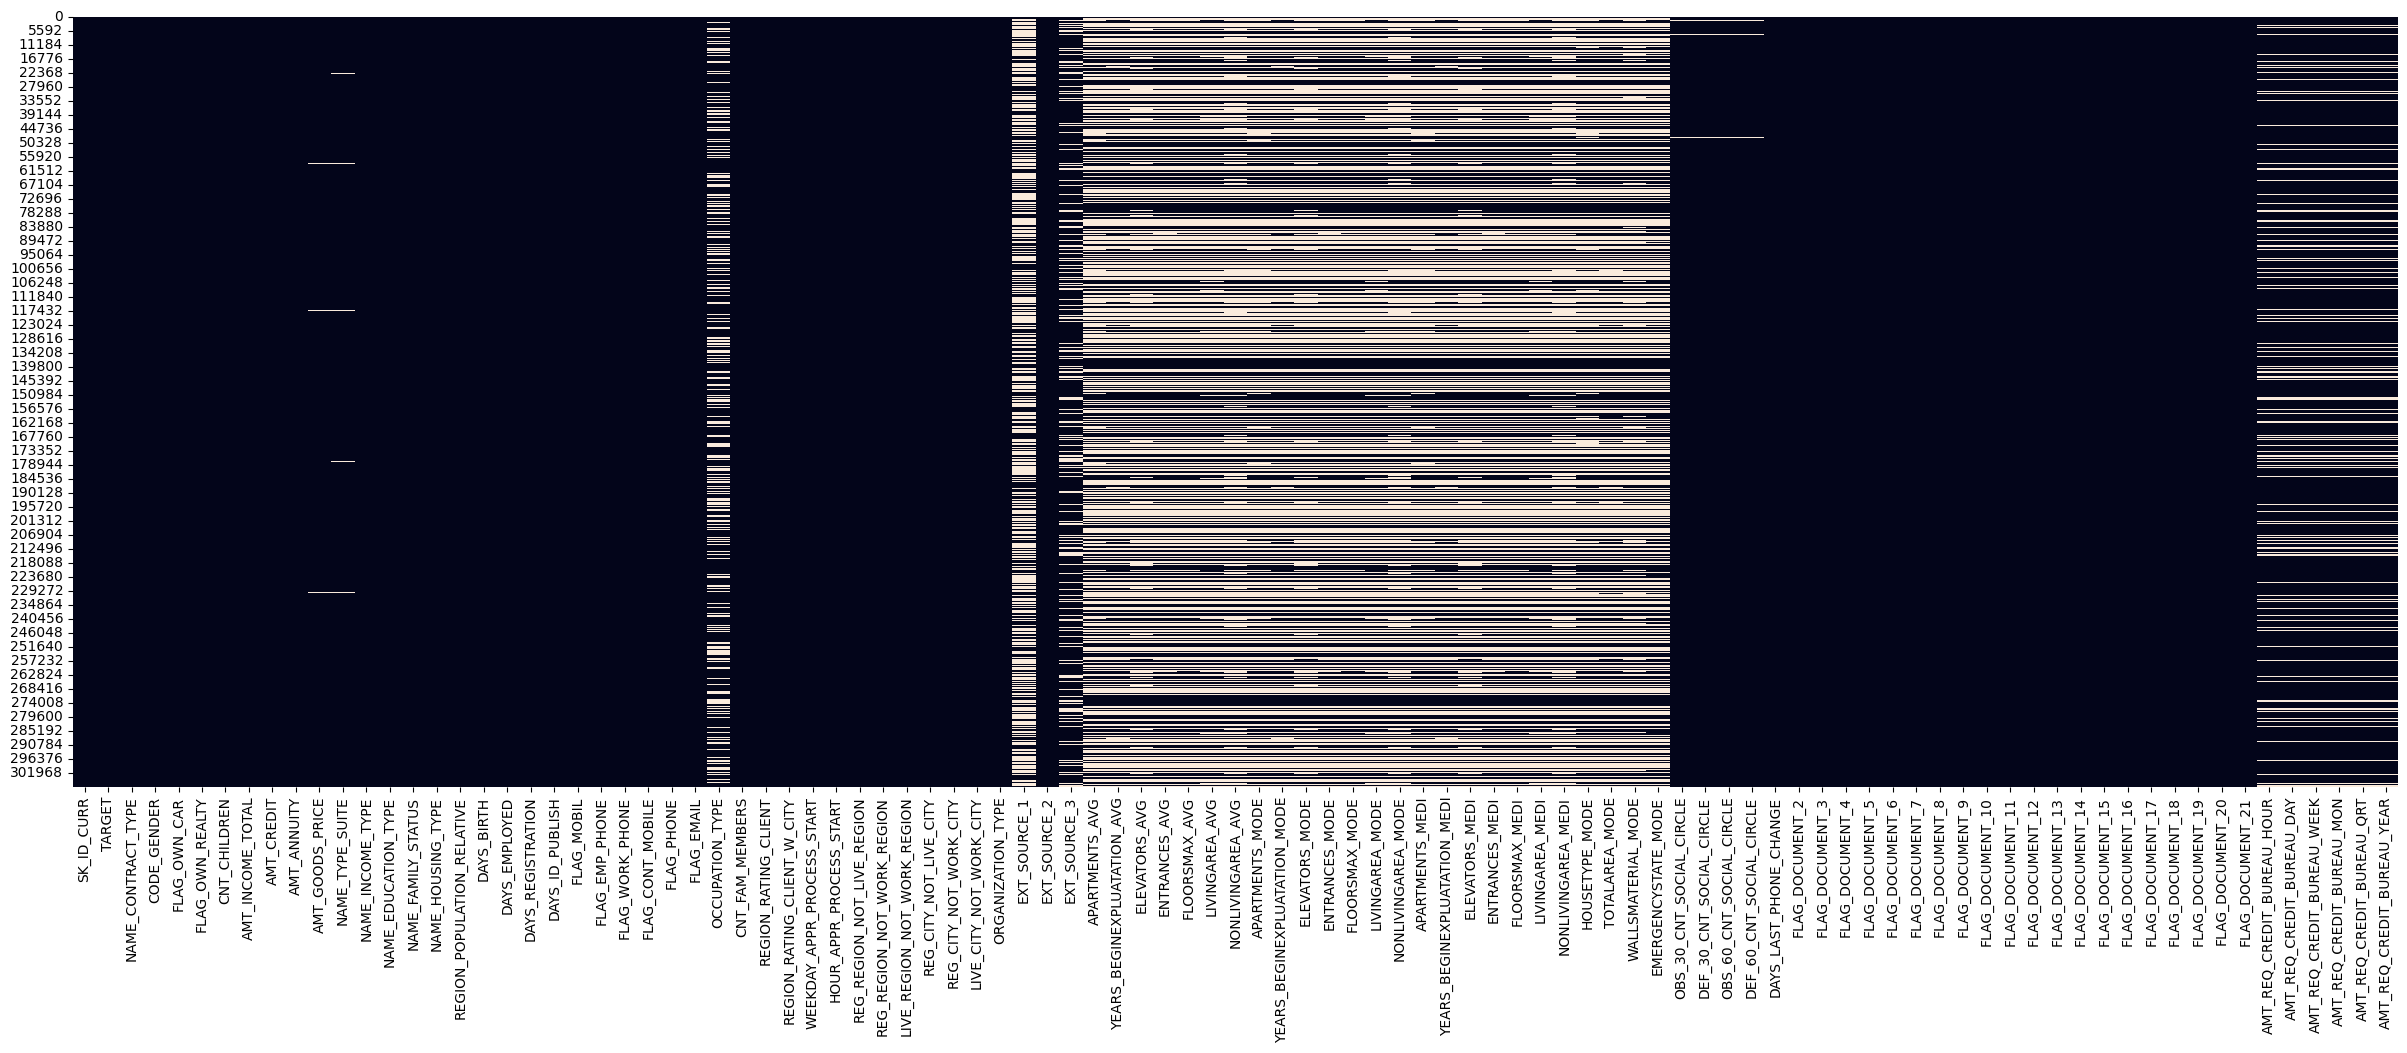

In [67]:
plt.figure(figsize=(30,10))
sns.heatmap(app_train.isna(), cbar=False)

In [68]:
app_train_duplicated= app_train.duplicated(subset=['SK_ID_CURR']).sum()
display_info(message=f'Nombre de prêts unique dupliqués : {app_train_duplicated}')

In [69]:
display_info(title="Examen de notre colonne TARGET", tag="h2", color="green")

In [70]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [71]:
display_info(message="On remarque que nos classes ne sont pas du tout équilibrées")
display_info(title="Affichons notre répartitoin de la colonne TARGET", tag="h2", color="green")

/var/folders/gk/r5q0c38n70s02t1z45pl1x400000gp/T/ipykernel_1534/1148136057.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([loan_map.get(int(item.get_text()),item.get_text()) for item in ax.get_xticklabels()])


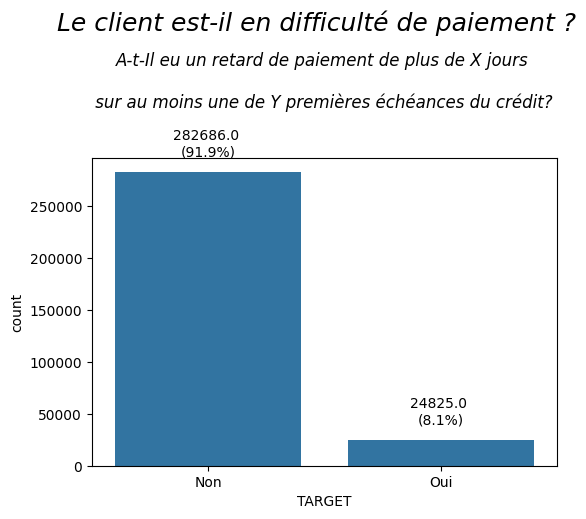

In [72]:
fig,ax = plt.subplots(figsize=(6,4))
loan_map = {
    1: "Oui",
    0: "Non",
}
sns.countplot(data=app_train,x='TARGET', ax=ax)
ax.set_xticklabels([loan_map.get(int(item.get_text()),item.get_text()) for item in ax.get_xticklabels()])

total = len(app_train)  # Total des valeurs
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / total
    ax.annotate(f'{height} \n({percentage:.1f}%)\n', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center')
    
plt.suptitle("Le client est-il en difficulté de paiement ?\n",
             y=1.25,fontsize=18, fontstyle='italic')
plt.title("A-t-Il eu un retard de paiement de plus de X jours \n\n sur au moins une de Y premières échéances du crédit? \n\n",
          loc="center",fontsize=12, fontstyle='italic')
plt.show()

In [73]:
display_info(message="histogrammes des variables continues", fontsize="24px")

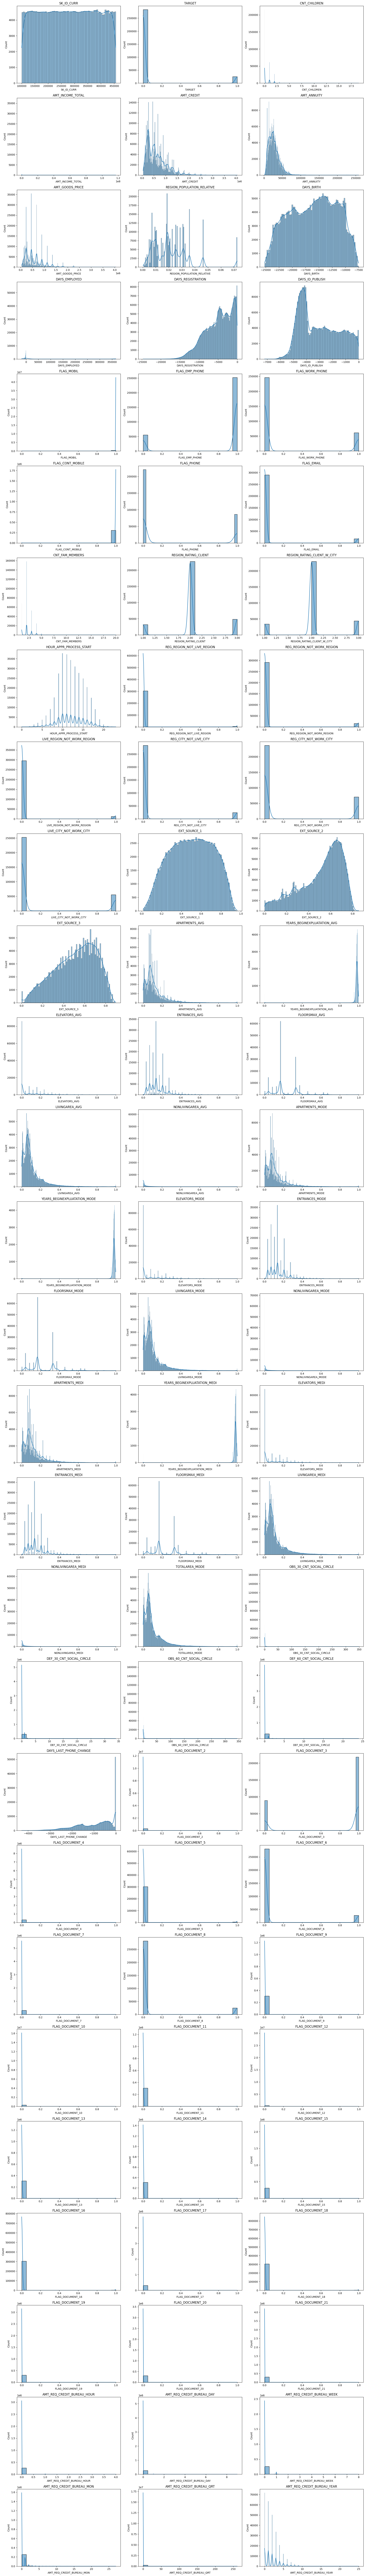

In [74]:

# Sélectionner les colonnes de type float64 et int64
numeric_columns = app_train.select_dtypes(include=['float64', 'int64']).columns

# Définir la taille de la grille (3 graphiques par ligne)
n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Calculer le nombre de lignes nécessaires

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  # Ajuster la taille de la figure

# Boucle sur chaque colonne numérique
for i, col in enumerate(numeric_columns):
    row = i // n_cols
    col_position = i % n_cols
    
    # Tracer le graphique dans l'axe correspondant avec histplot
    sns.histplot(app_train[col], ax=axes[row, col_position], kde=True)
    axes[row, col_position].set_title(col)  # Ajouter un titre pour chaque sous-graphe

# Supprimer les axes vides si le nombre de graphiques n'est pas un multiple de 3
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()  # Ajuste la mise en page pour éviter le chevauchement
plt.show()

In [75]:
display_info(title="Compréhension des différentes variables", color="green")
display_info(message="On remarque que certaines variable on une distribution asymétrique.")
display_info(message="En revanche aucune d'elle ne suis une distribution normal")
display_info(message="Ses données n'ont pas l'air d'avoir été standardisées")


Text(0, 0.5, 'Nombre de clients')

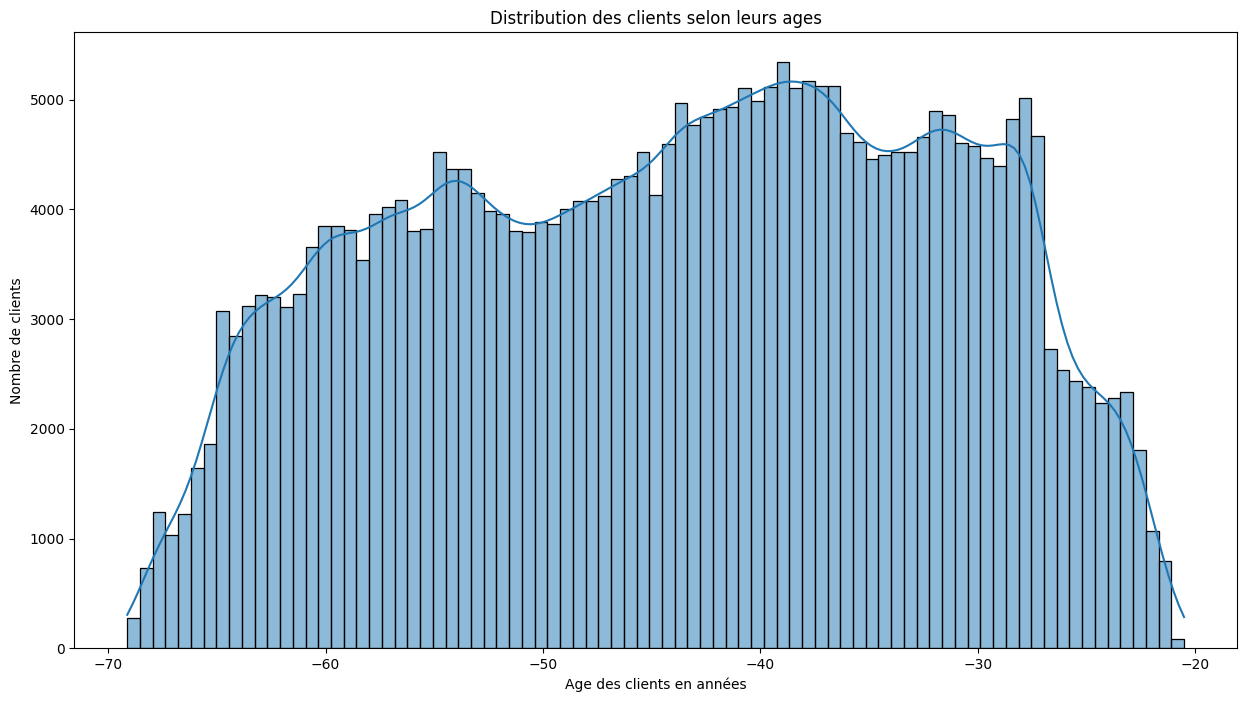

In [76]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.histplot(app_train['DAYS_BIRTH']/365, kde=True)
ax.set_title('Distribution des clients selon leurs ages')
ax.set_xlabel('Age des clients en années')
ax.set_ylabel('Nombre de clients')

In [77]:
display_info(message="L'age des client oscille entre 20 et 70 ans ce qui parait cohérent")

Text(0, 0.5, 'Nombre de clients')

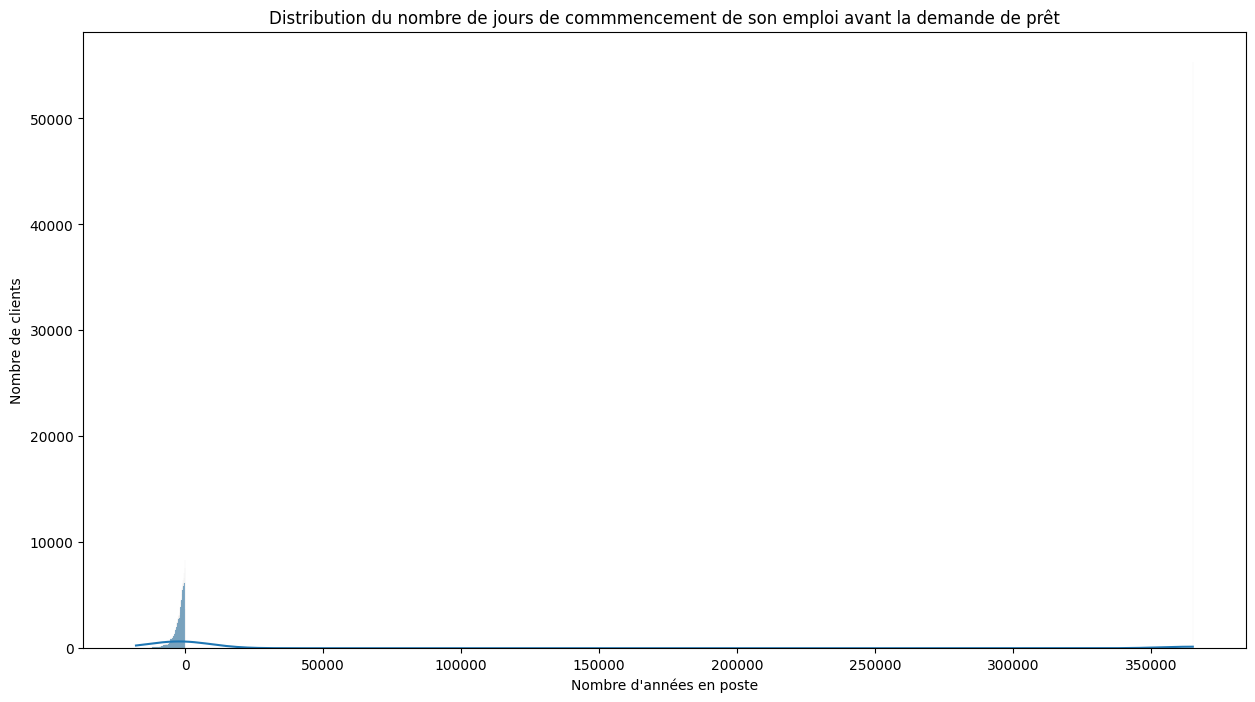

In [78]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.histplot(app_train['DAYS_EMPLOYED'], kde=True)
ax.set_title('Distribution du nombre de jours de commmencement de son emploi avant la demande de prêt')
ax.set_xlabel('Nombre d\'années en poste')
ax.set_ylabel('Nombre de clients')

In [79]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [80]:
display_info(message="'DAYS_EMPLOYED' qui represente le nombre de jours avant la candidature ou la personne a commencé son emploi actuel a des valeurs positive</br>Ce qui n'est pas possible car cette variable est relative à la date d'application")

In [81]:
# display_info(title="Variables Qualitative")
display_info(message="Variables Qualitative", fontsize="24px")

In [82]:
display_info(message="On visualise dans un premier temps la liste des valeurs pour les différentes variables catégorielles:", fontsize="18px")
for col in app_train.select_dtypes('object'):
    print(f'{col:-<50} {app_train[col].unique()}')

NAME_CONTRACT_TYPE-------------------------------- ['Cash loans' 'Revolving loans']
CODE_GENDER--------------------------------------- ['M' 'F' 'XNA']
FLAG_OWN_CAR-------------------------------------- ['N' 'Y']
FLAG_OWN_REALTY----------------------------------- ['Y' 'N']
NAME_TYPE_SUITE----------------------------------- ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE---------------------------------- ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE------------------------------- ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS-------------------------------- ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE--------------------------------- ['House / apartment' 'Rented apartment' 'With parents'
 'Muni

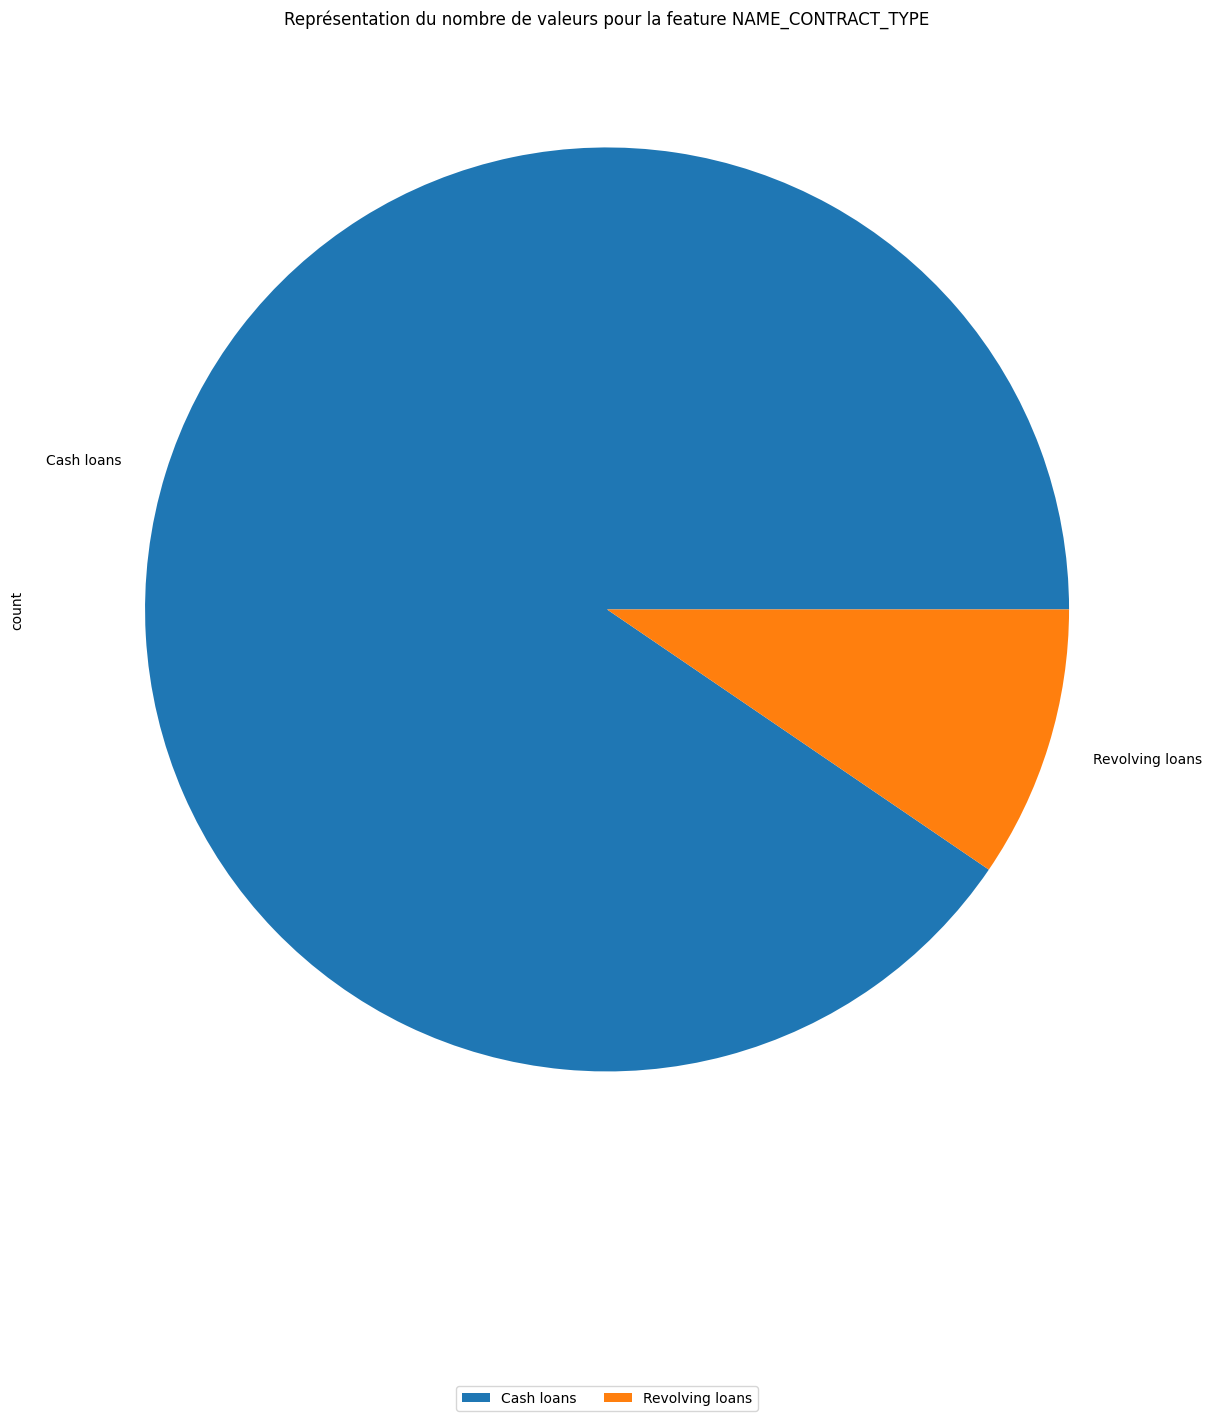

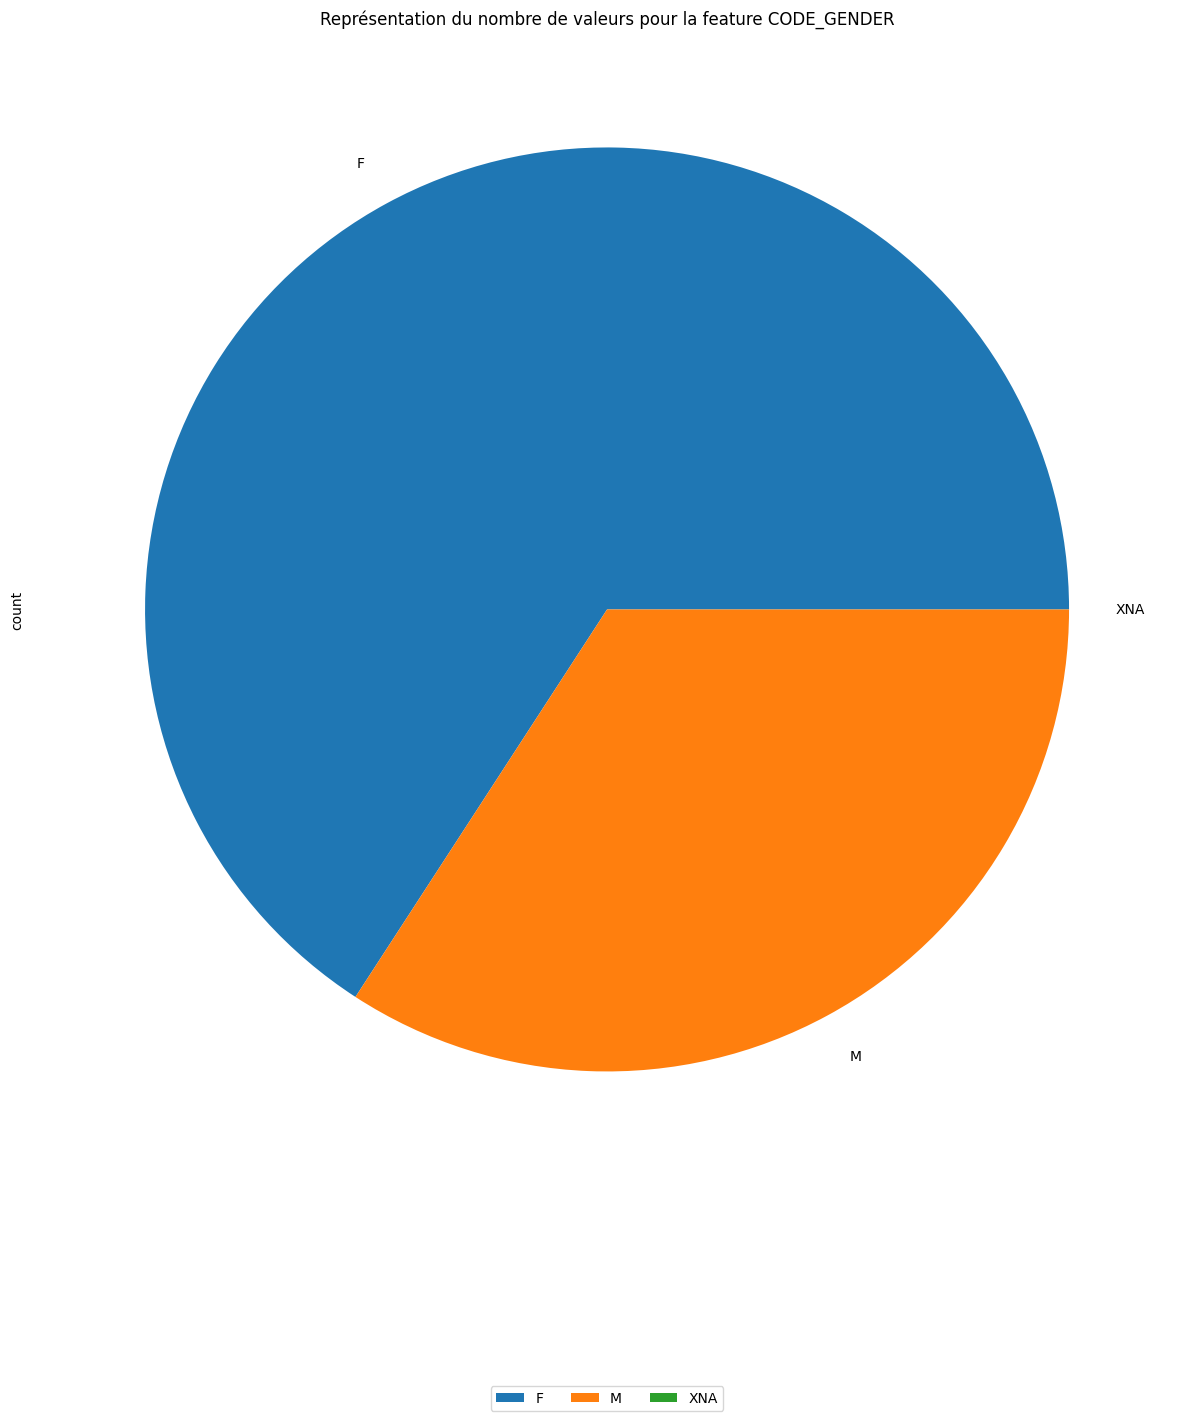

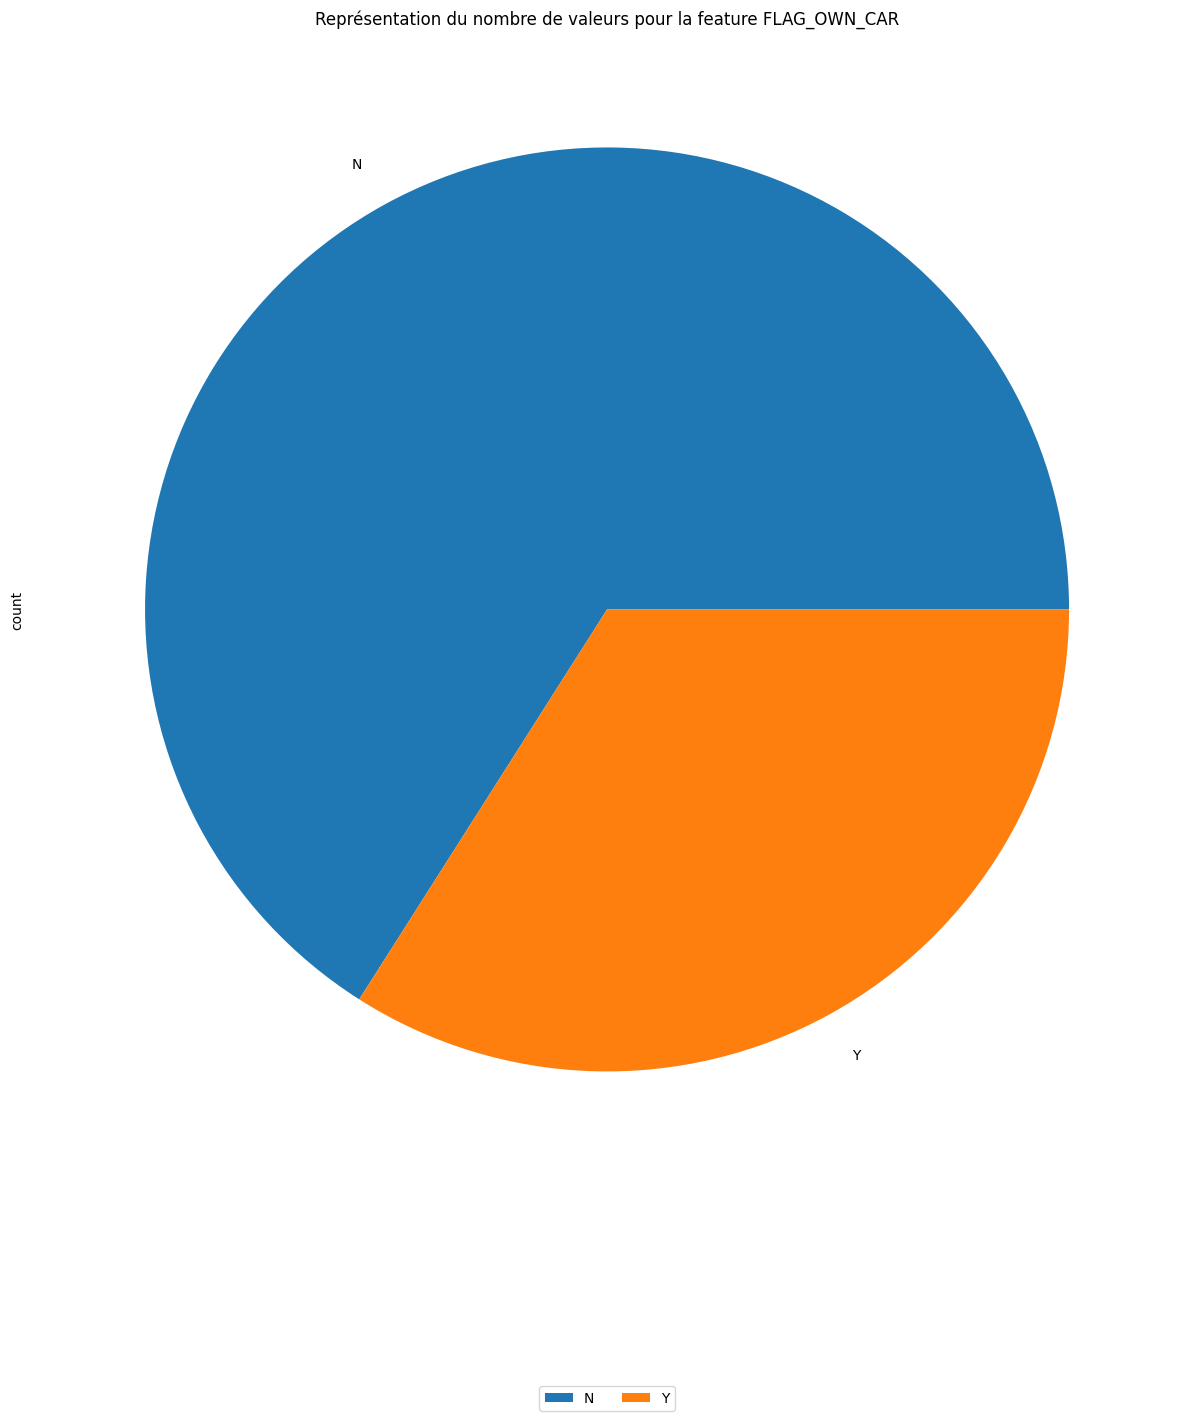

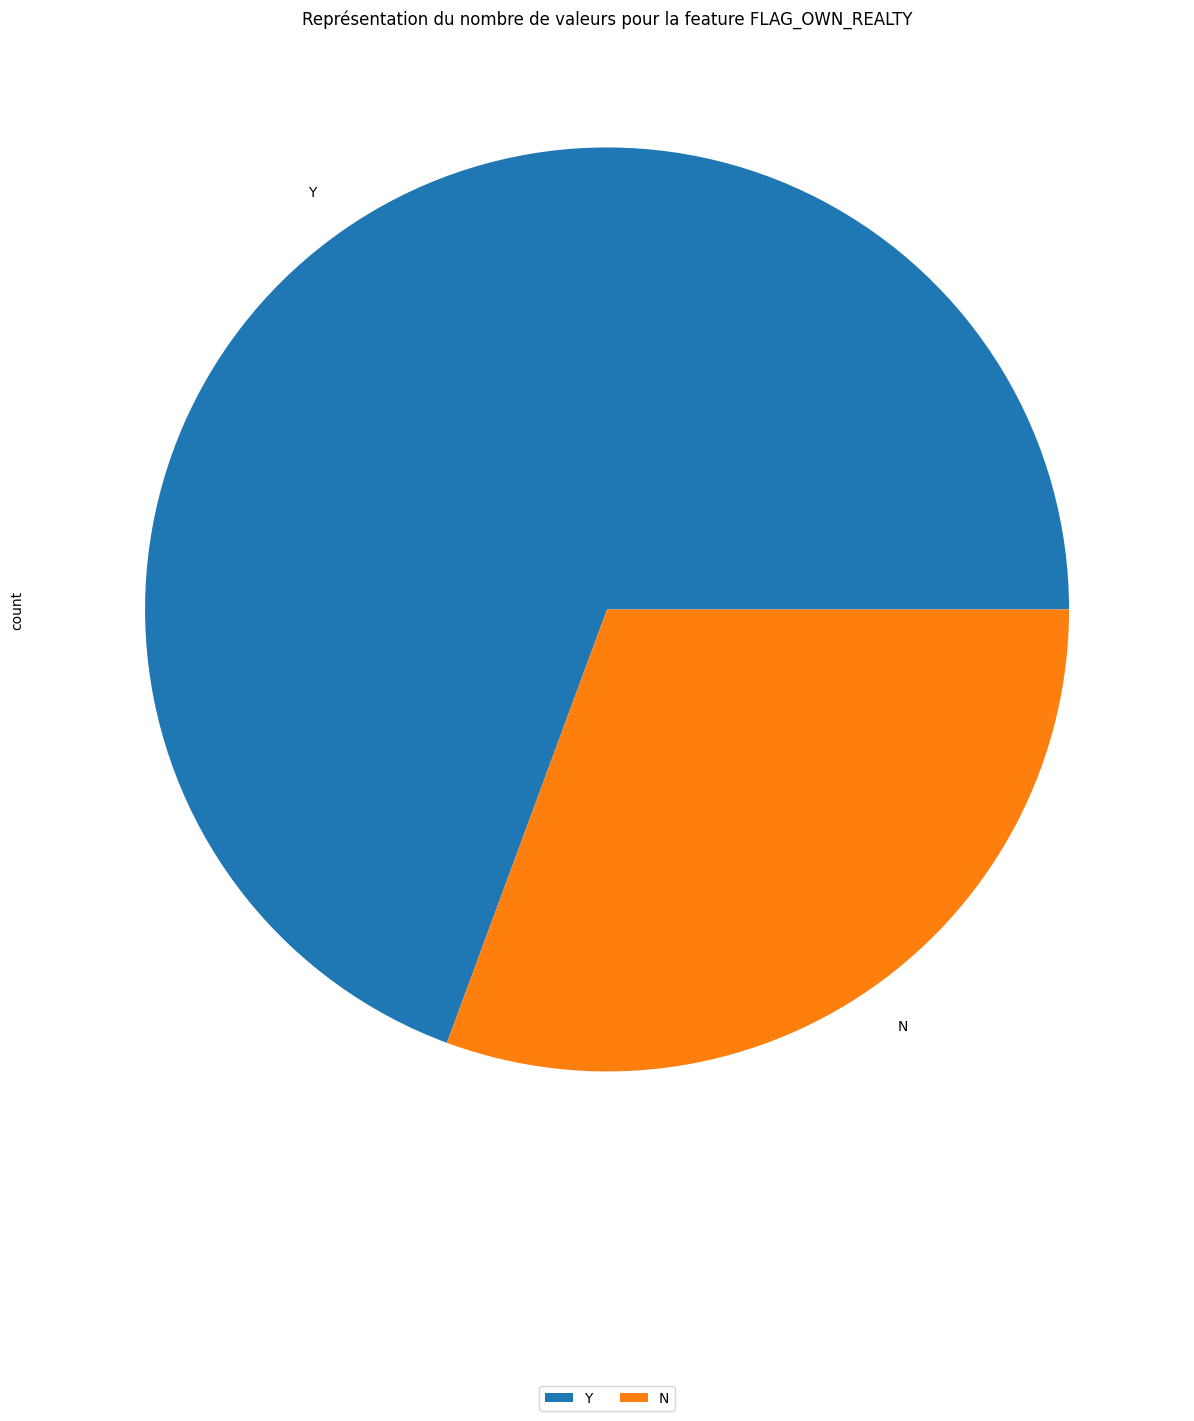

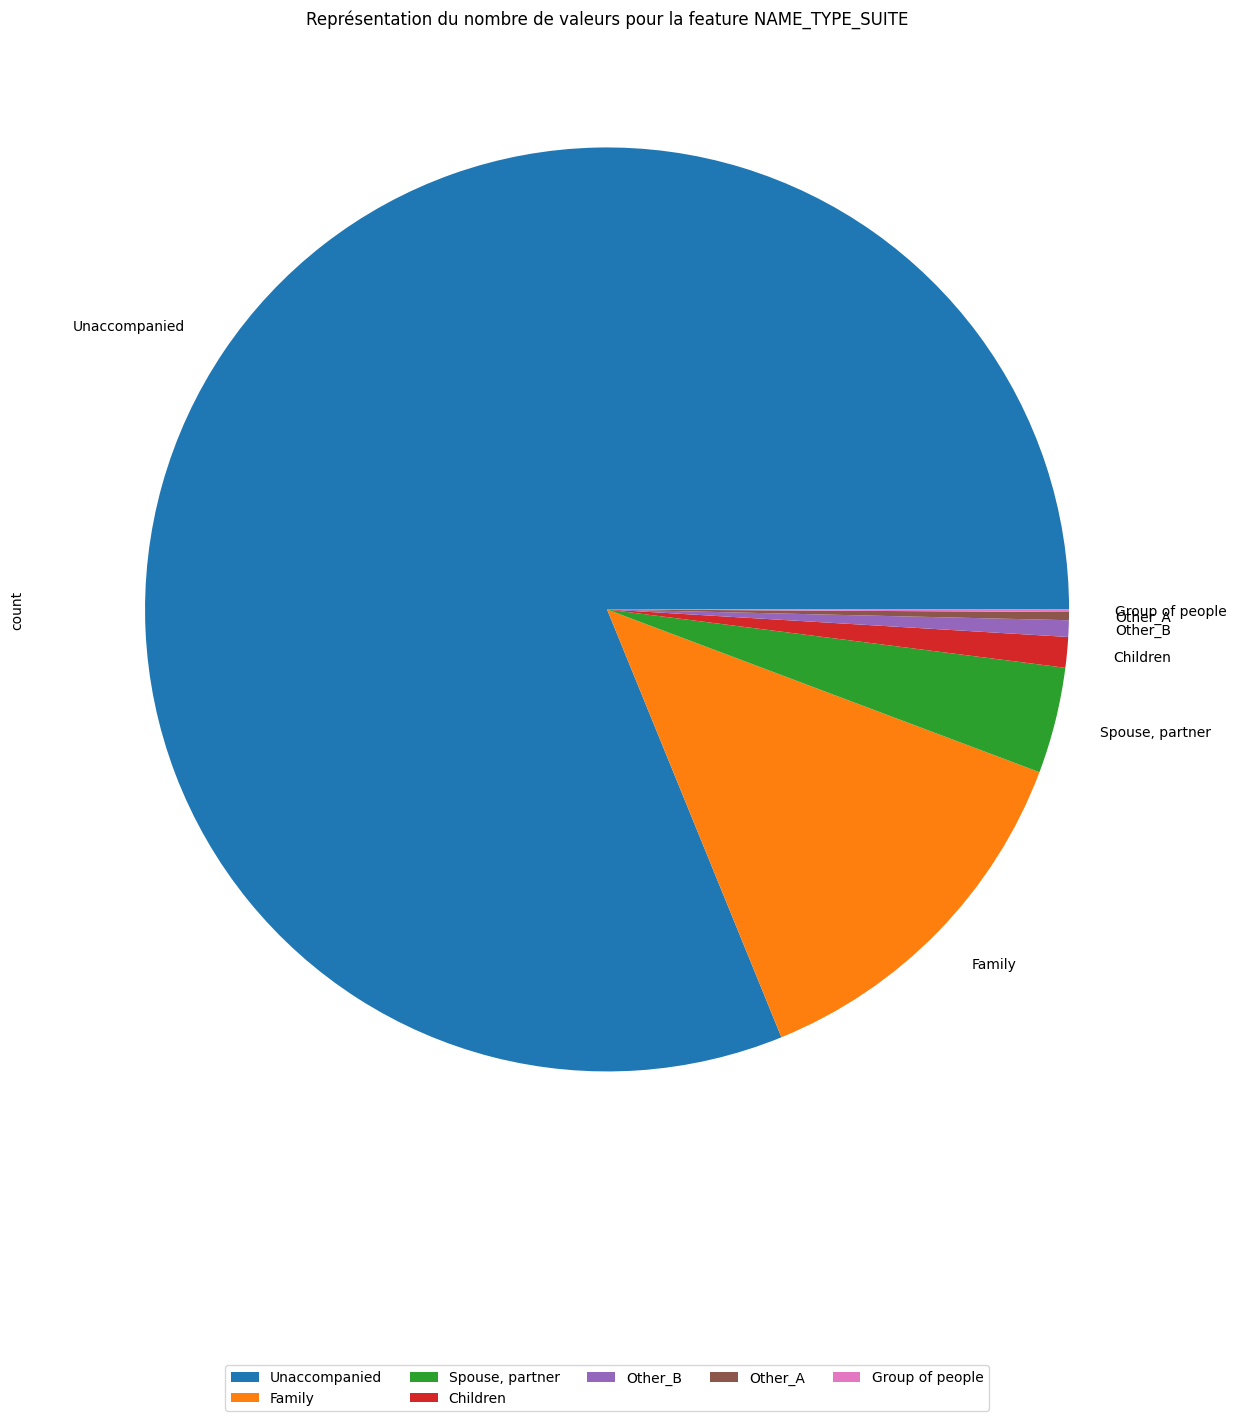

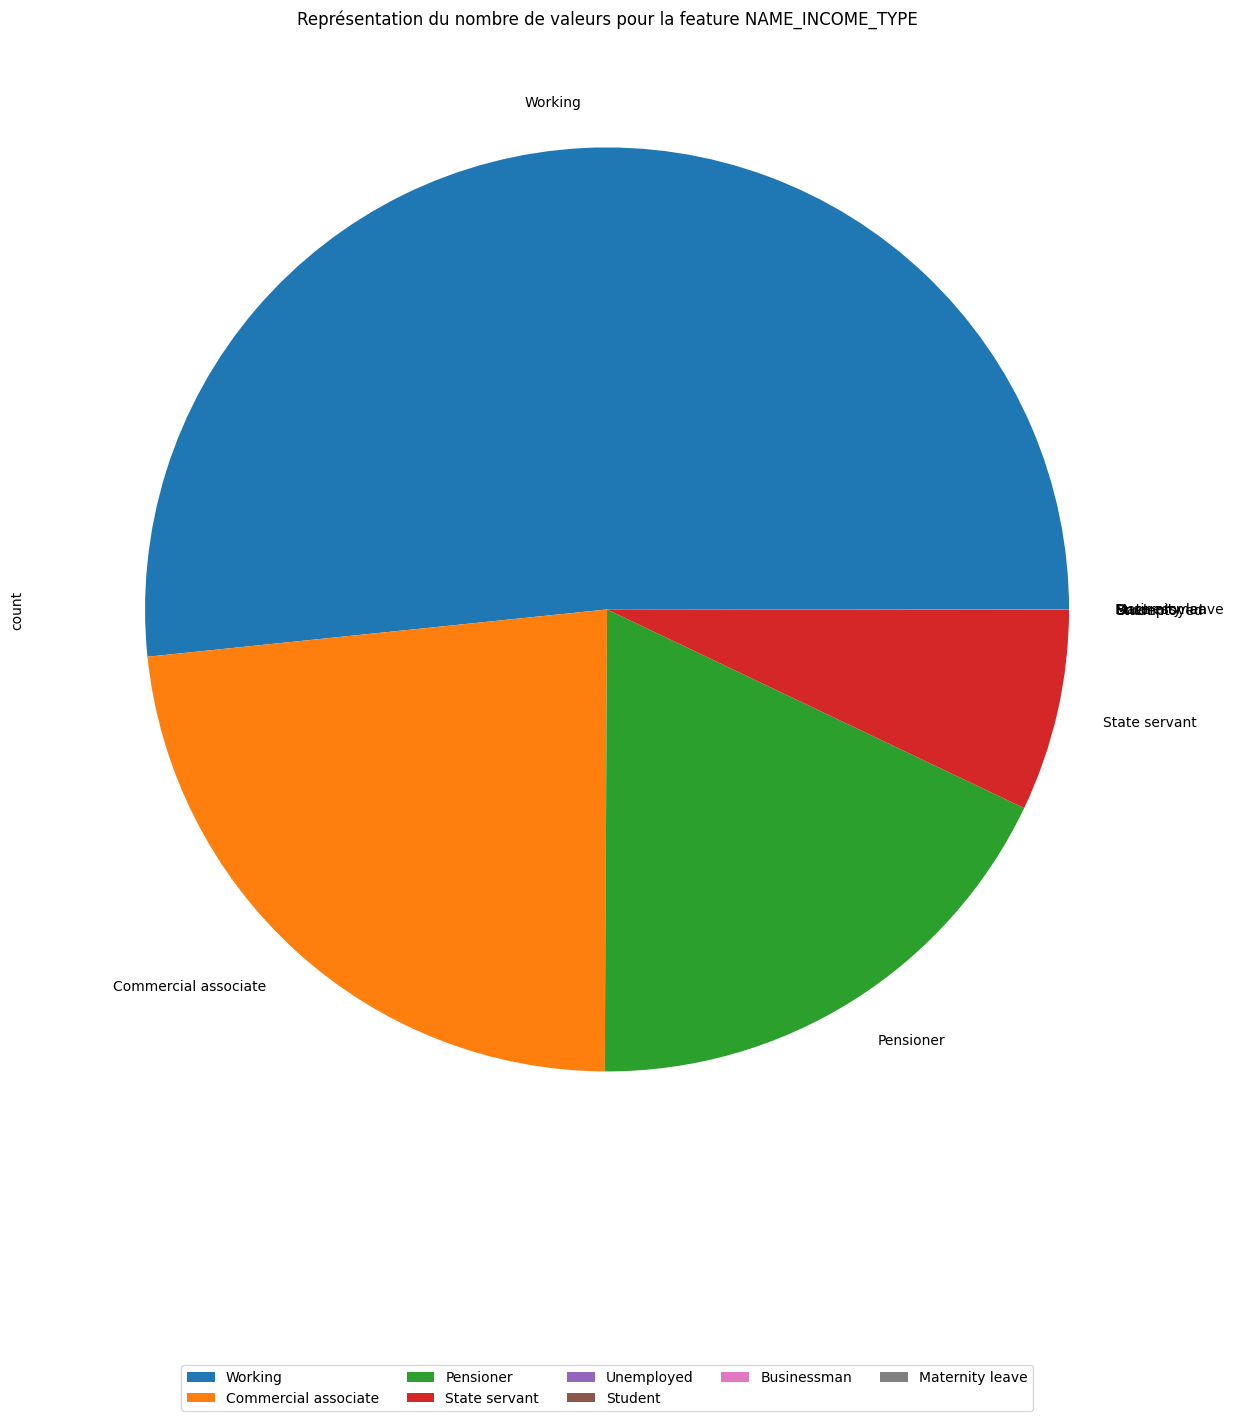

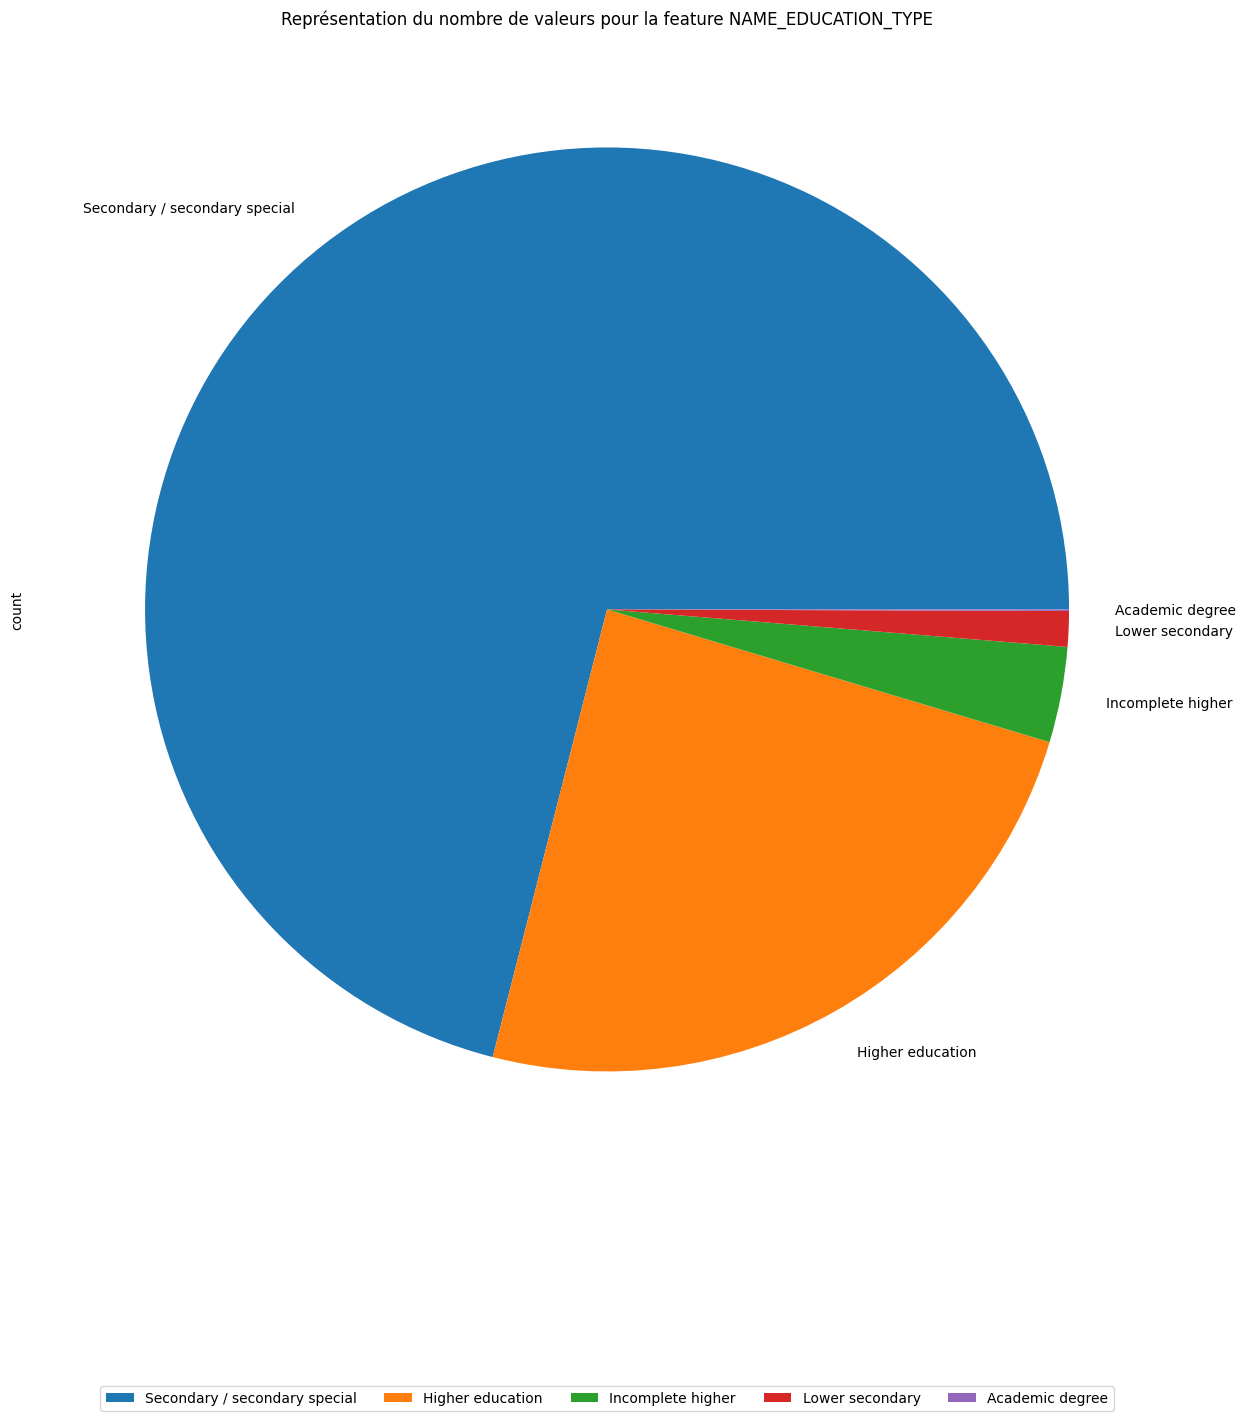

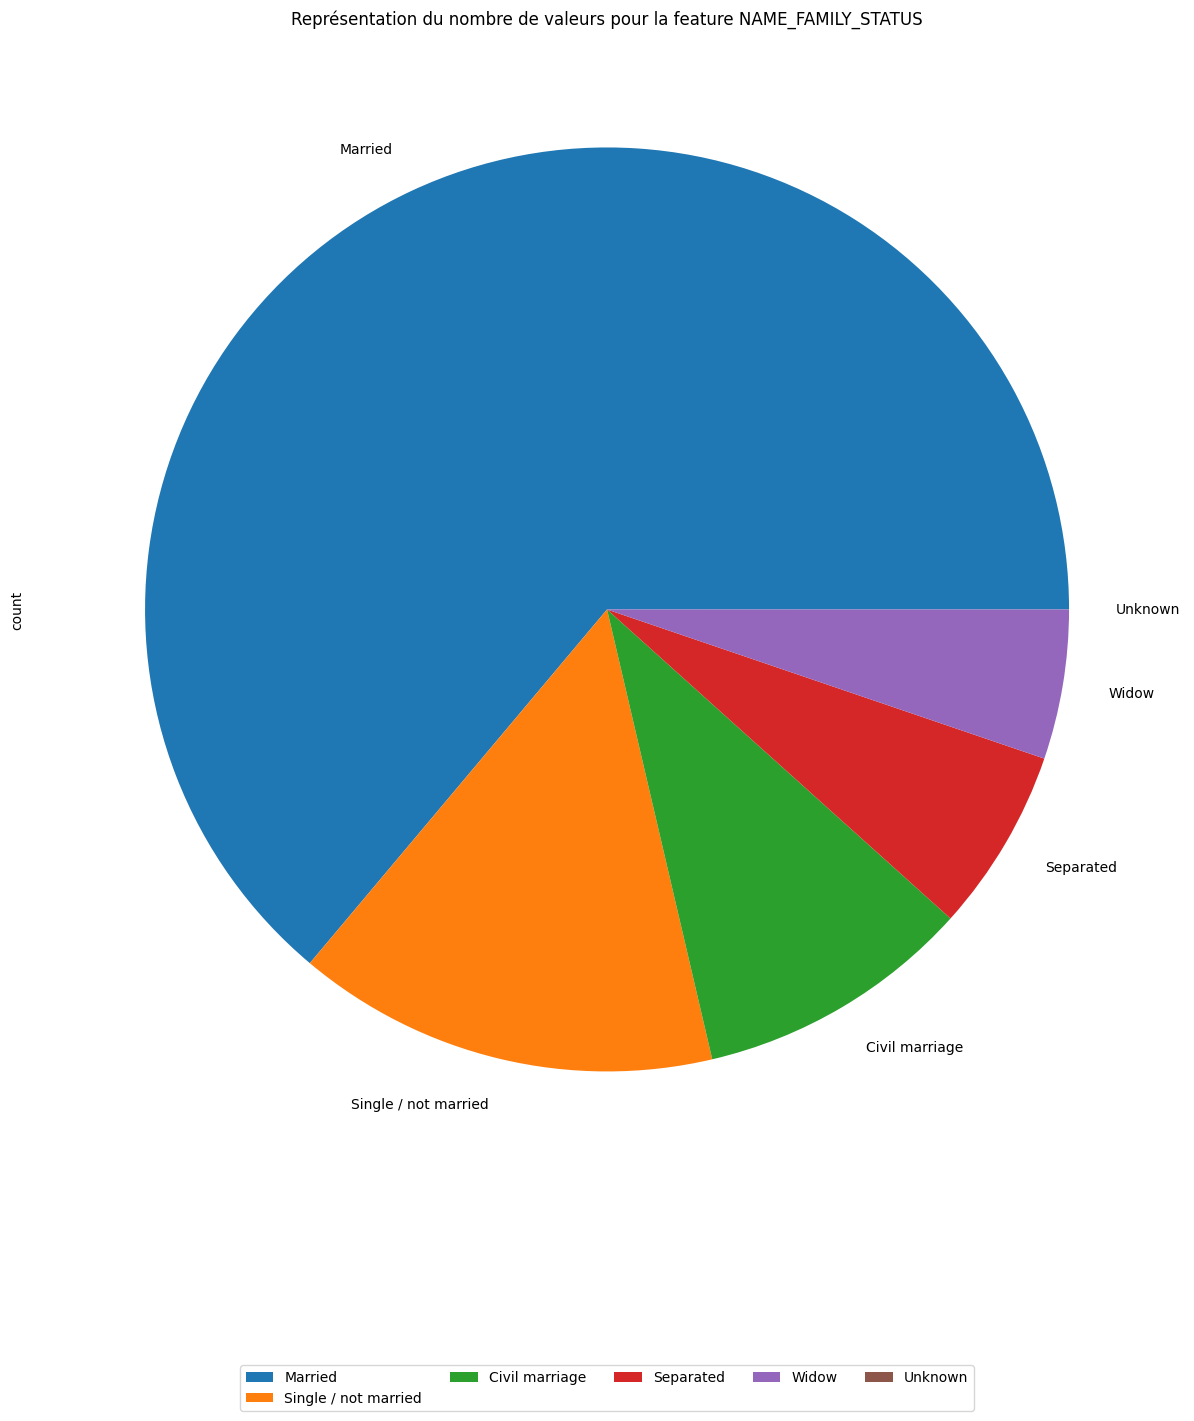

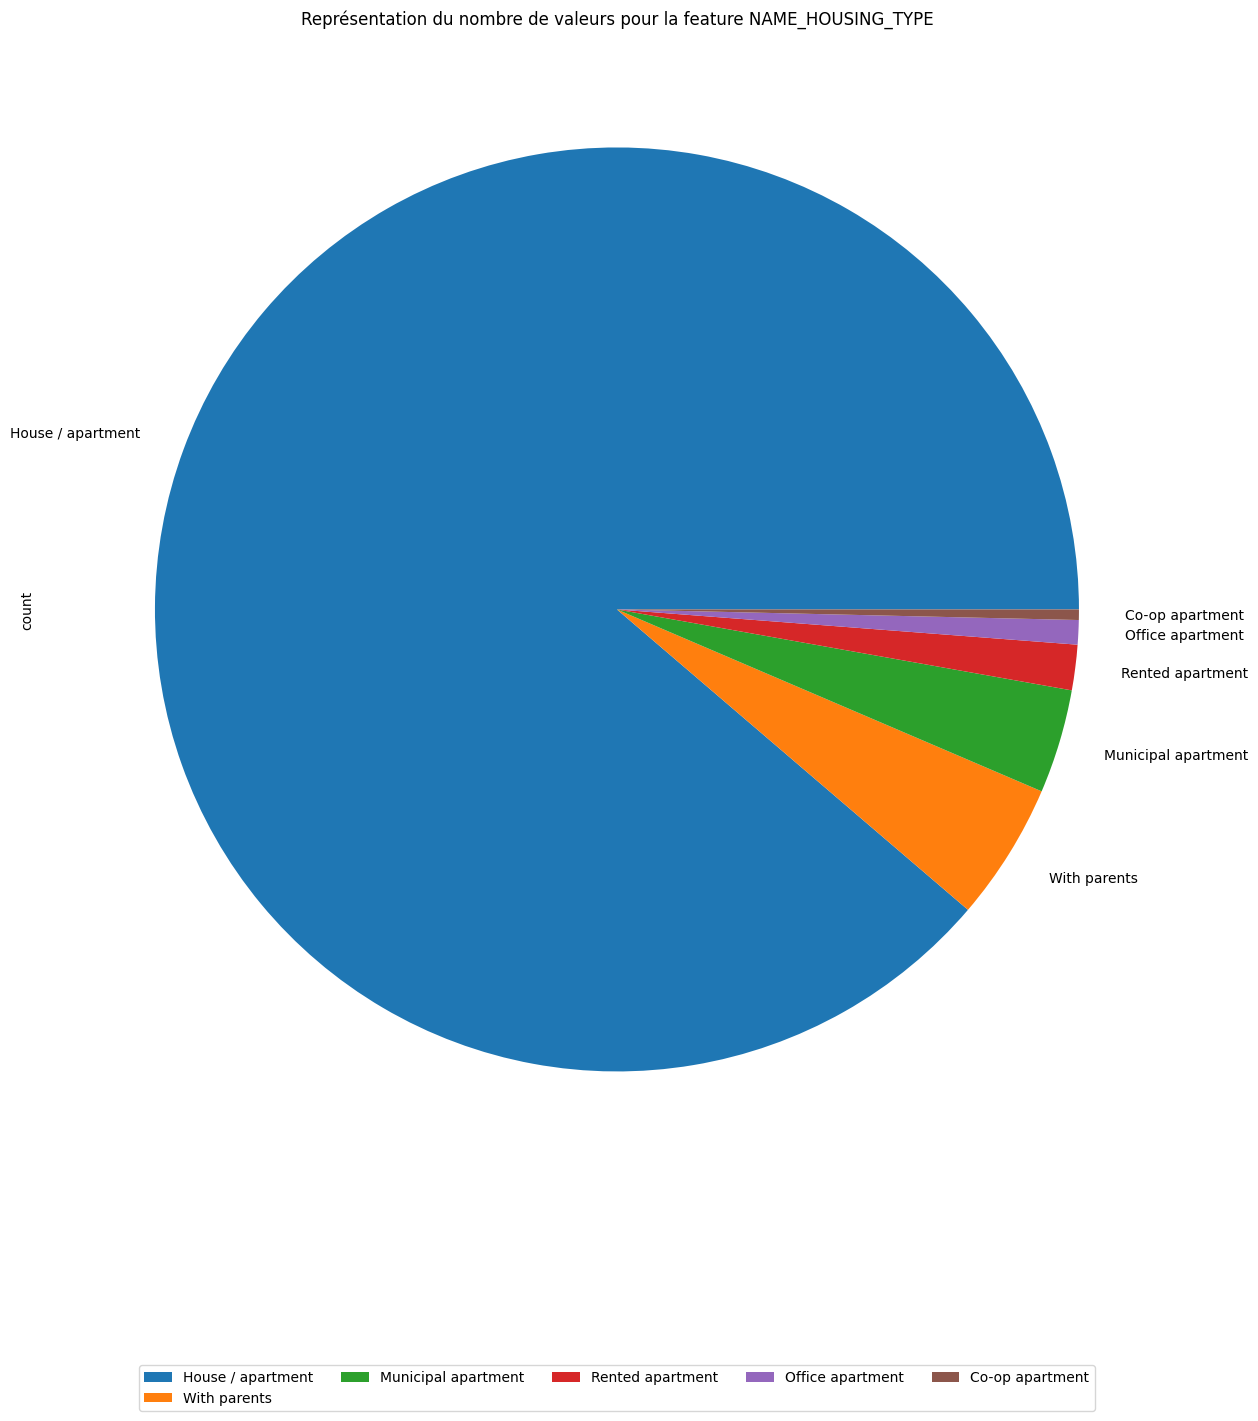

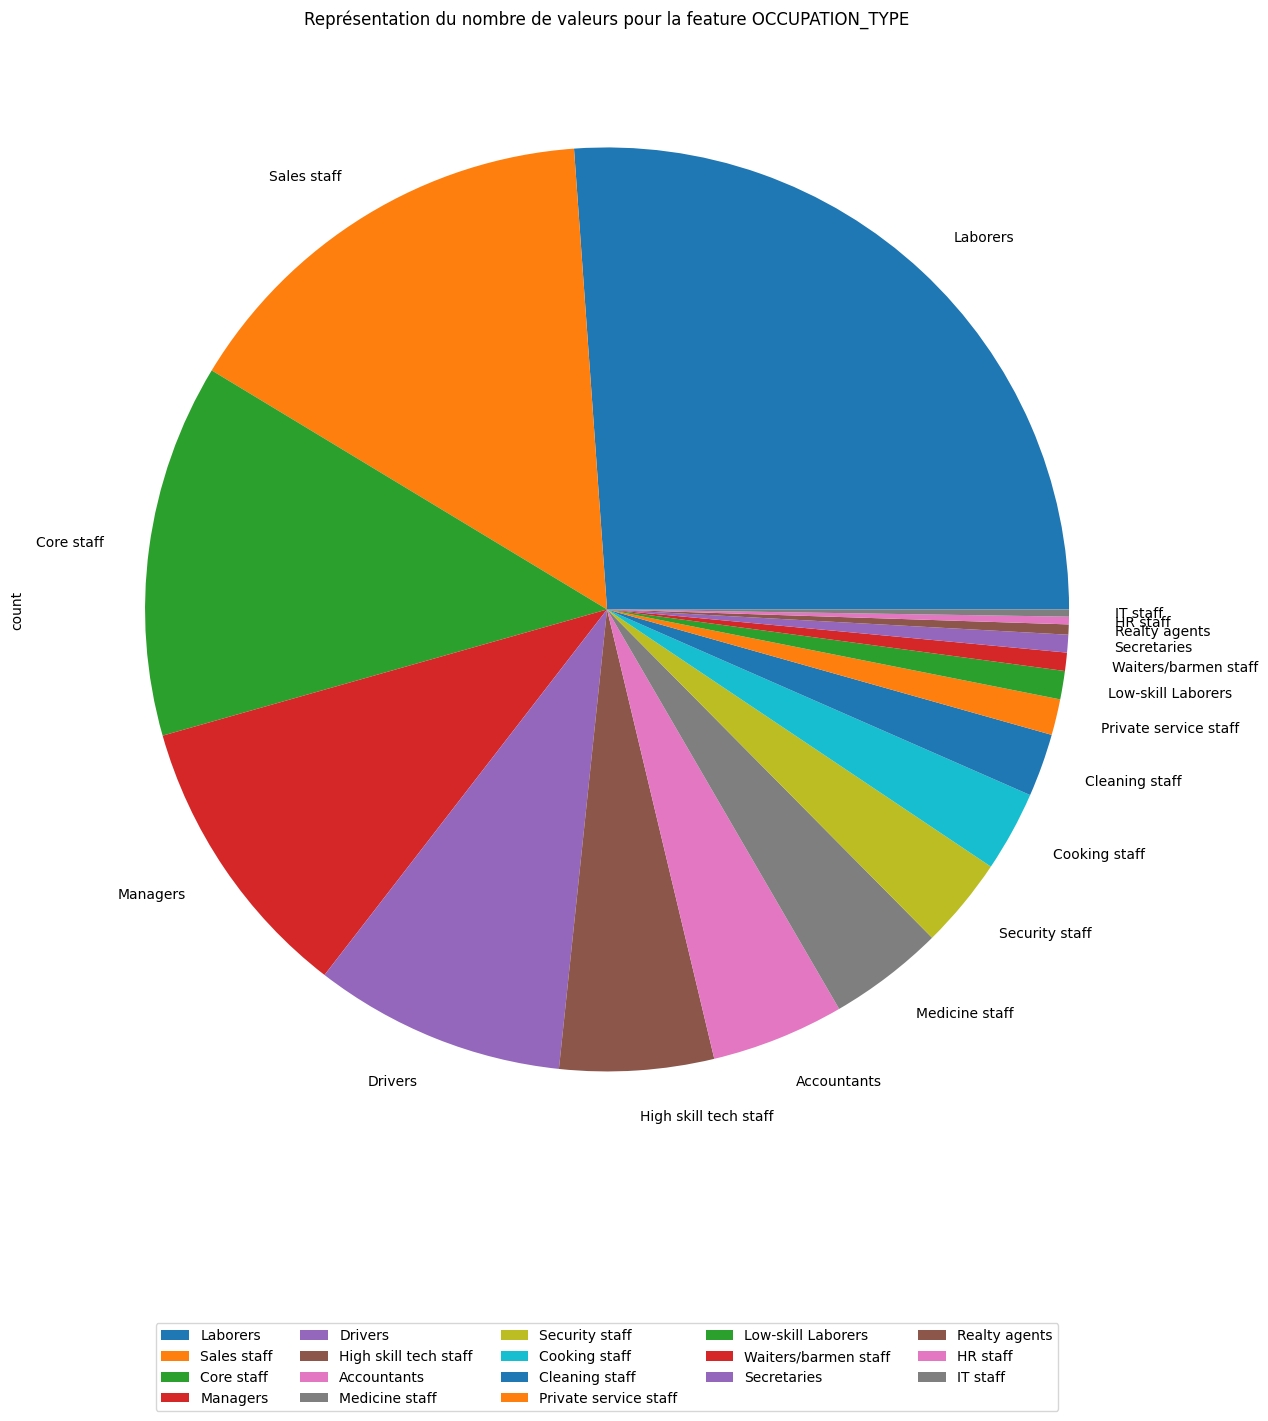

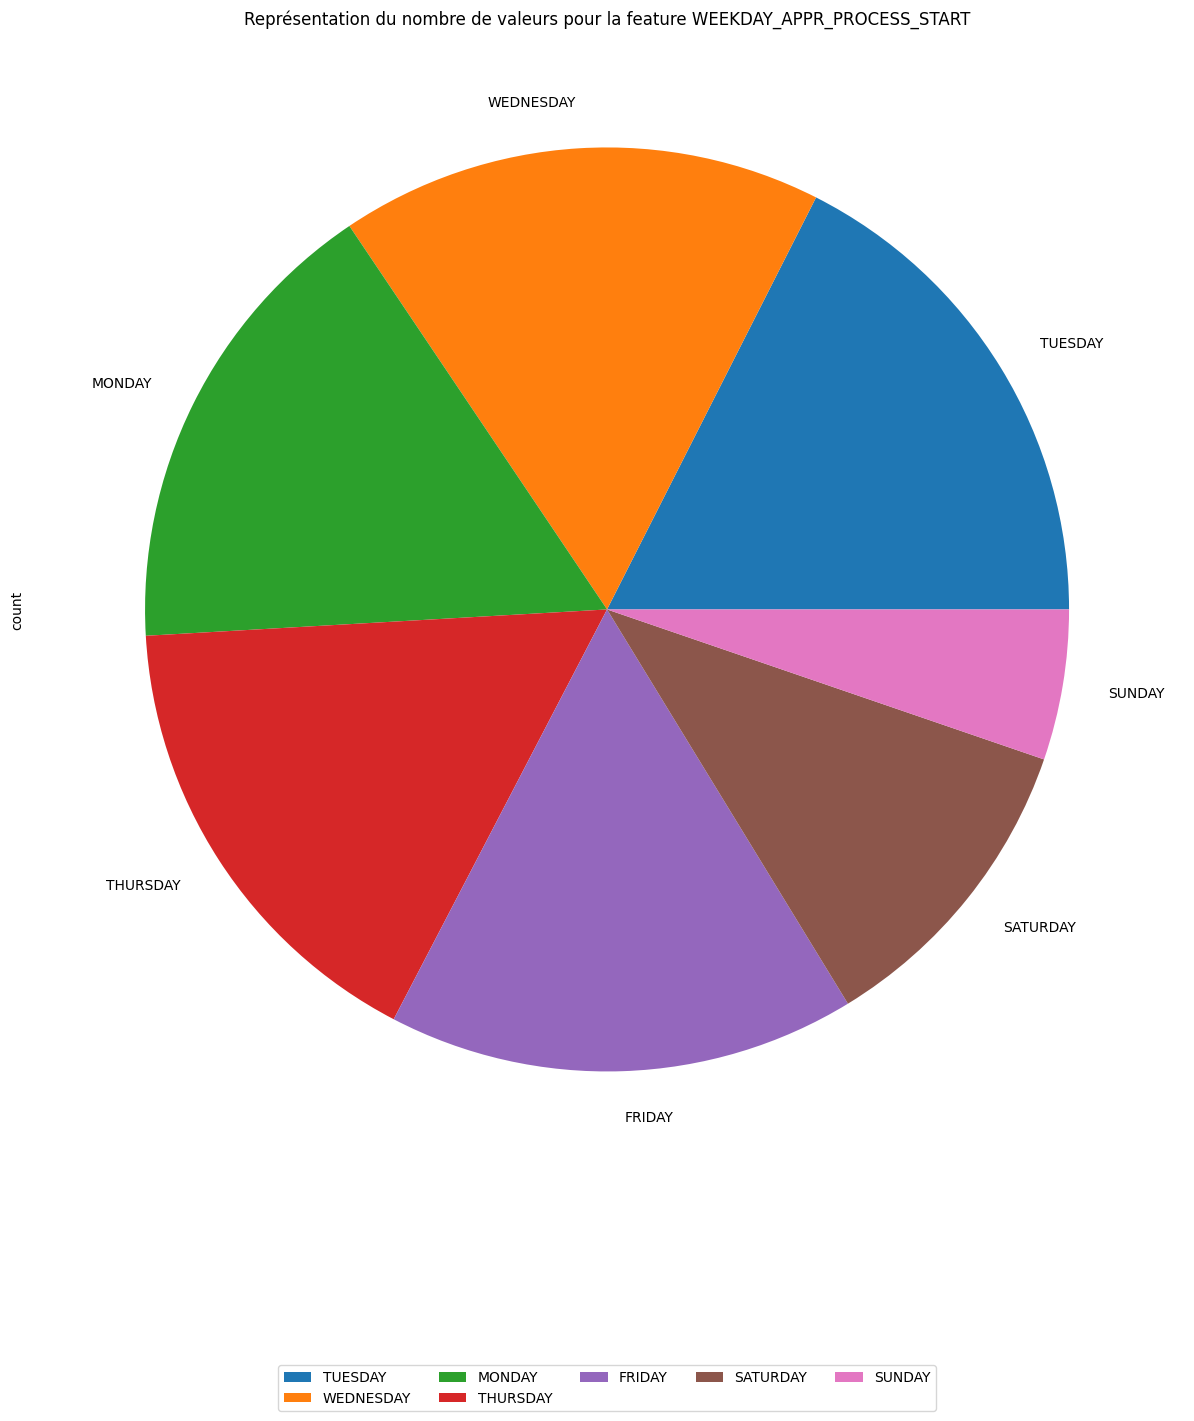

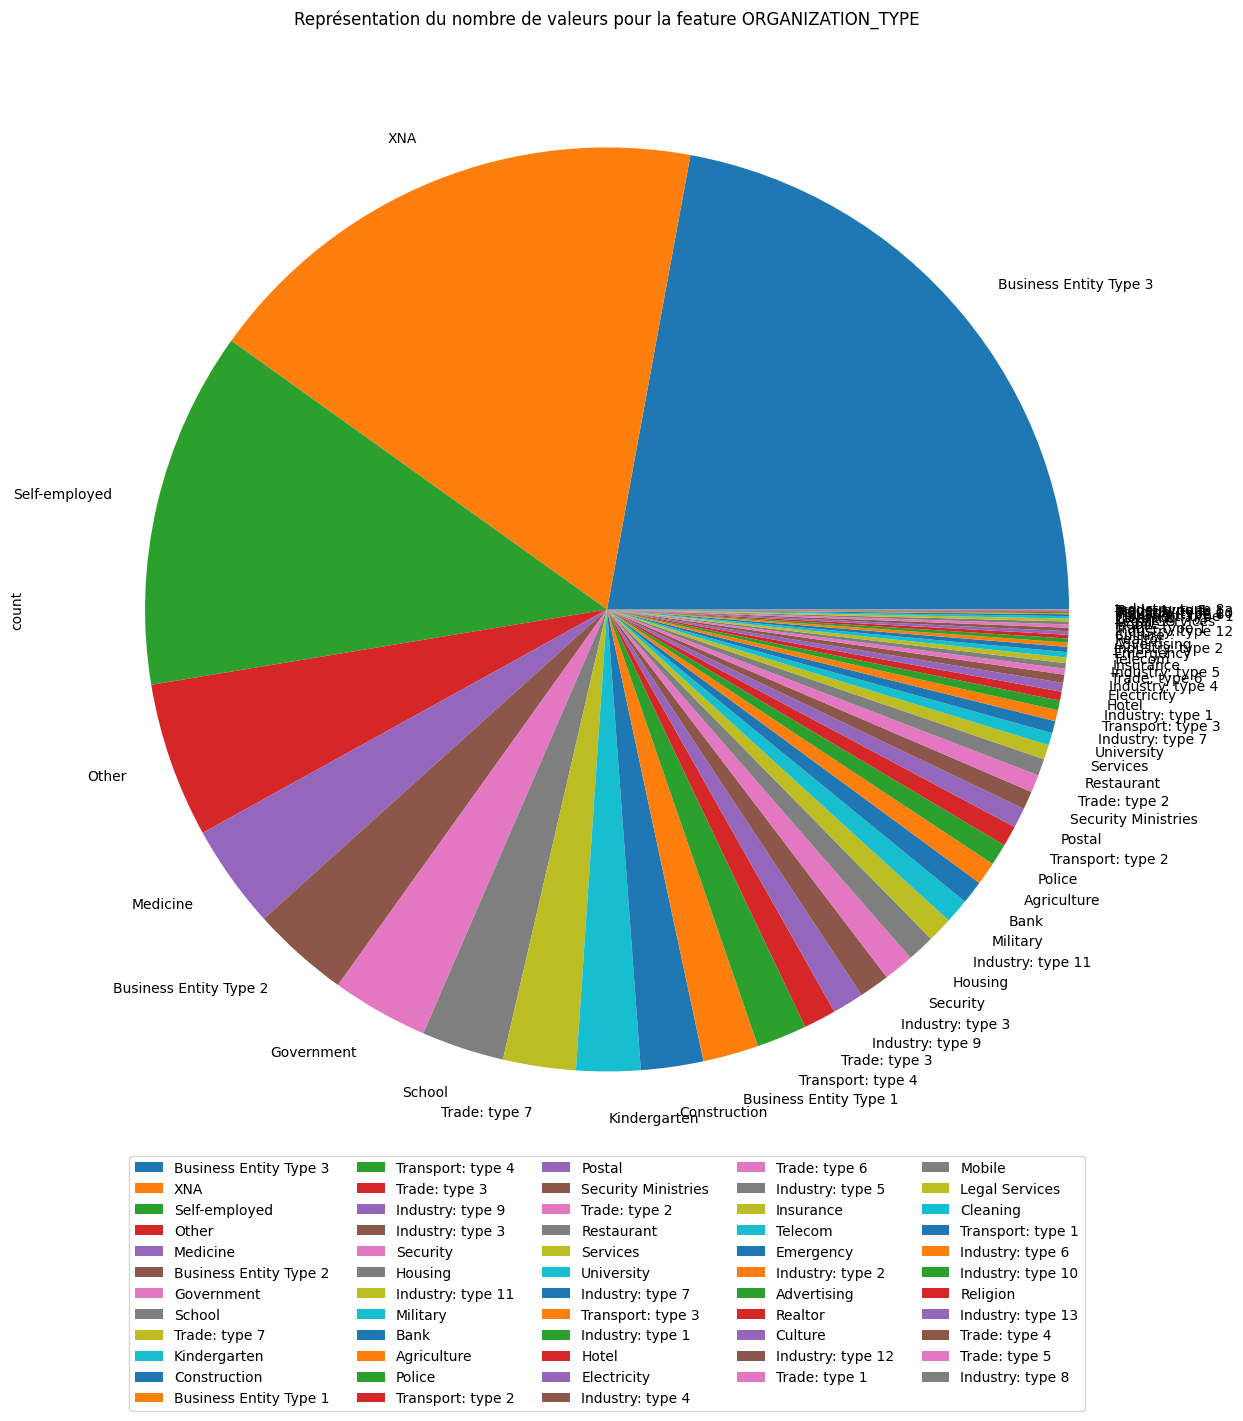

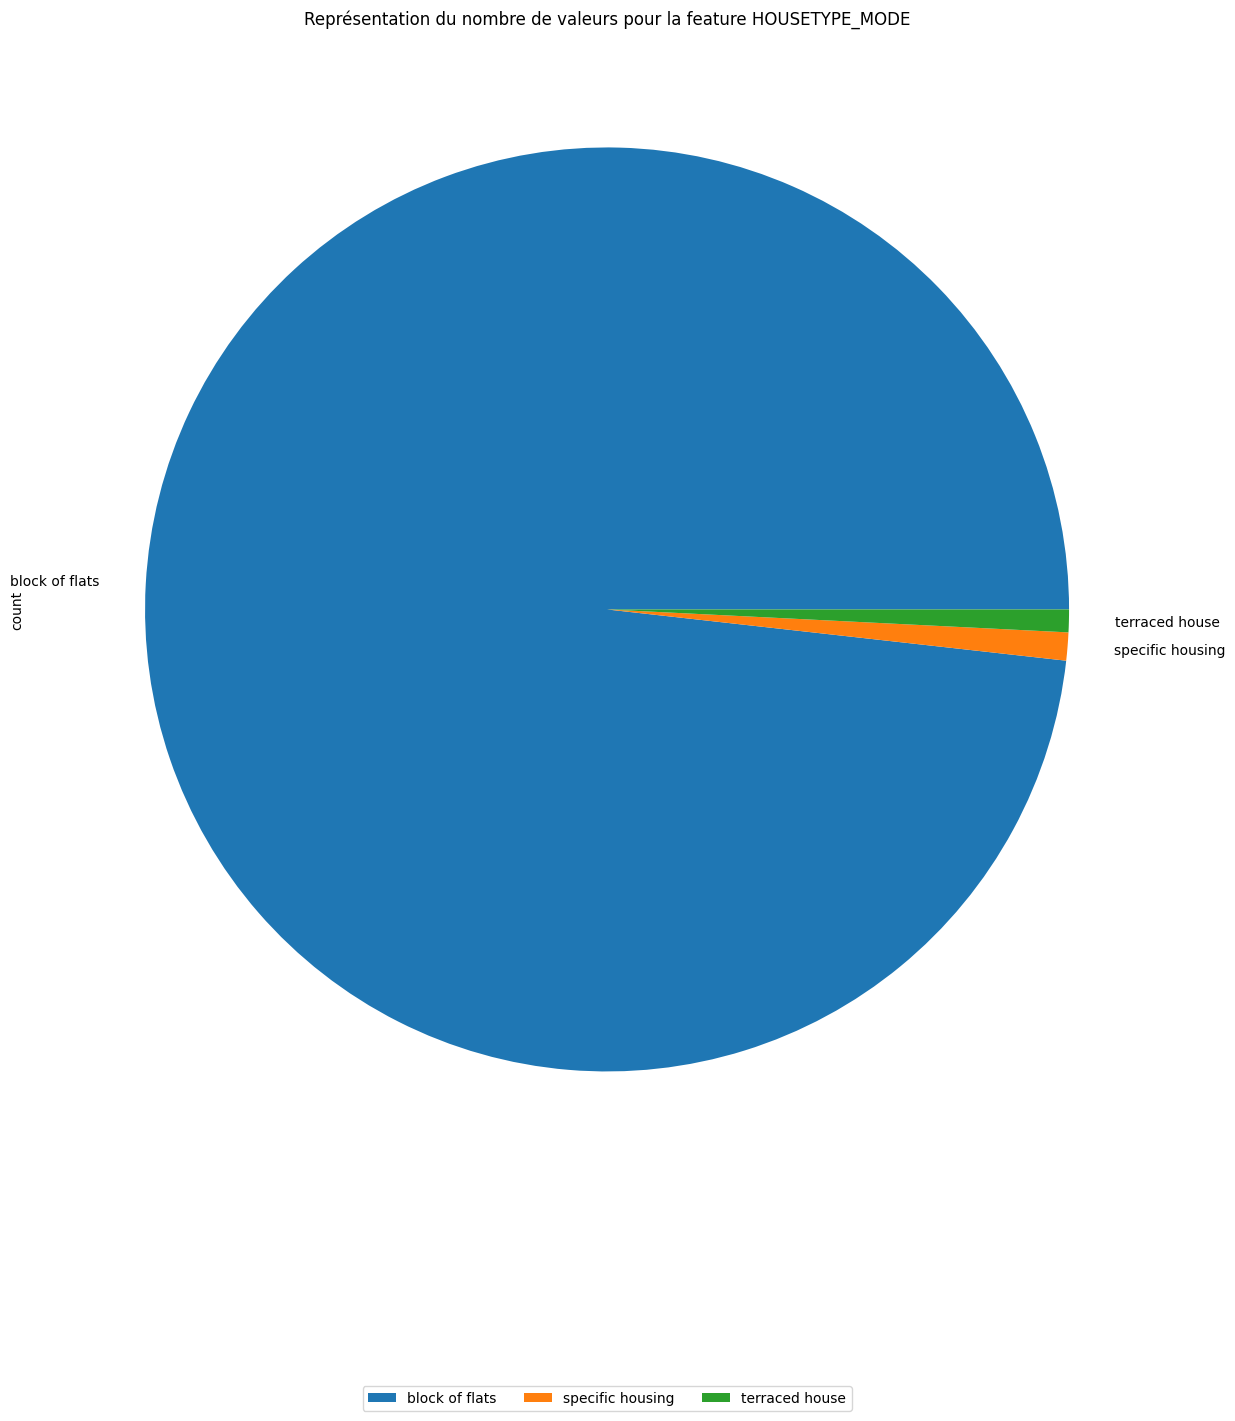

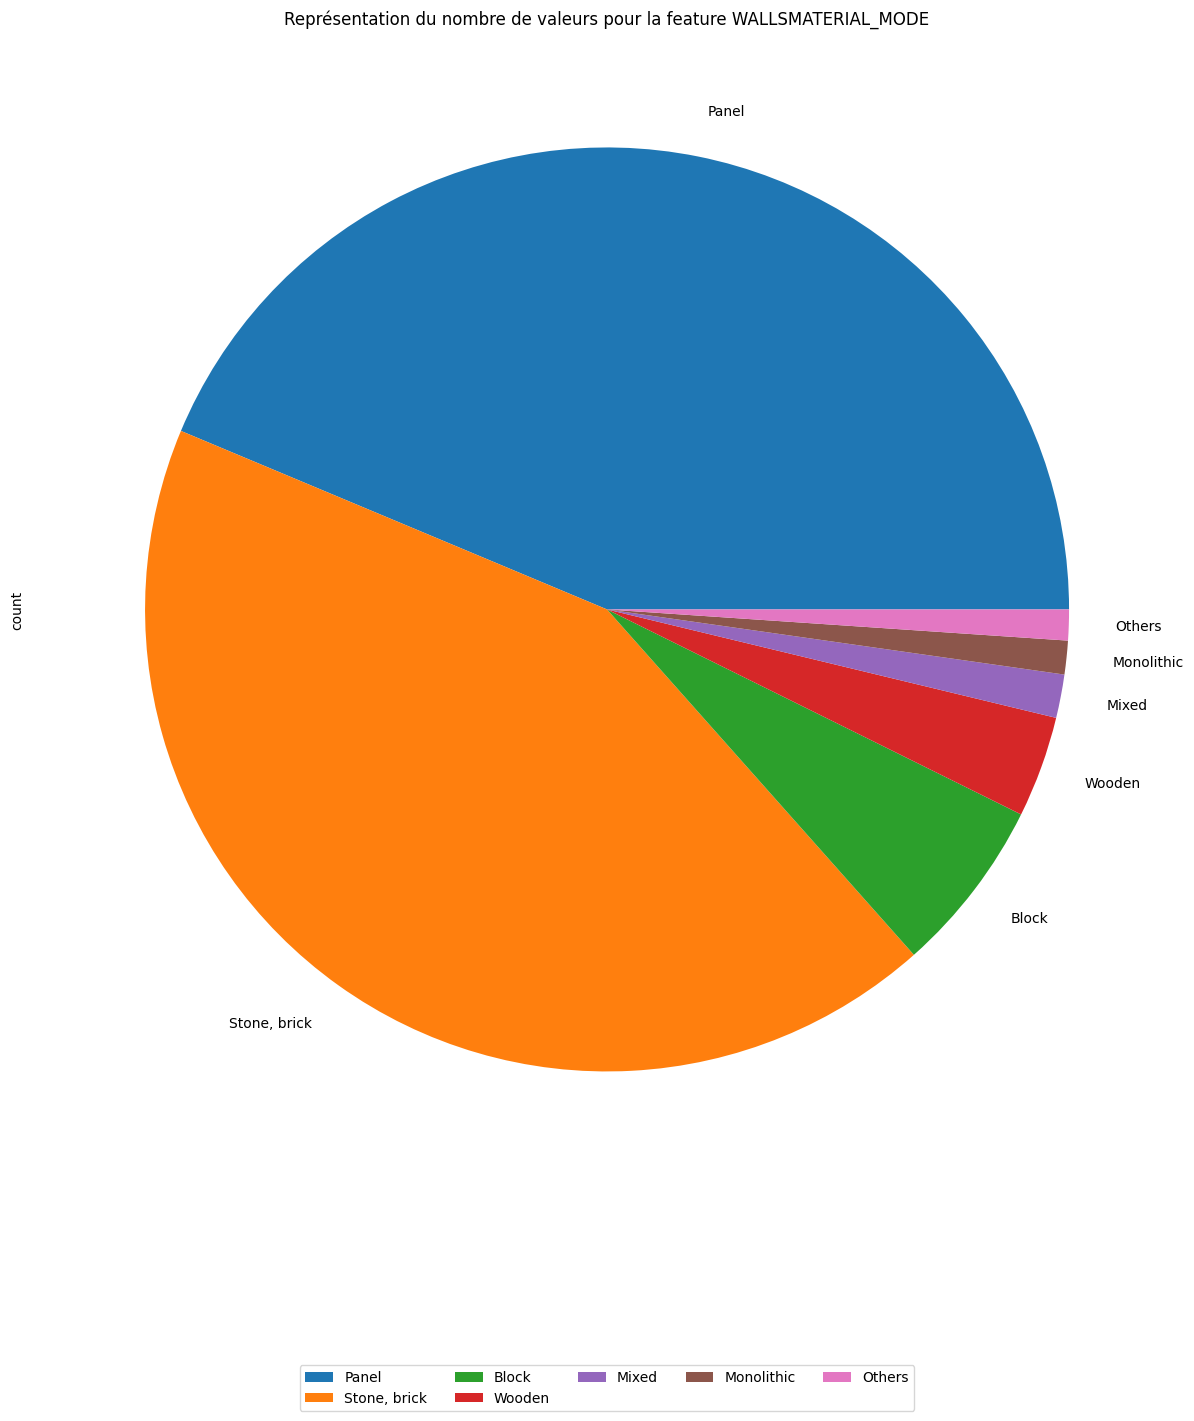

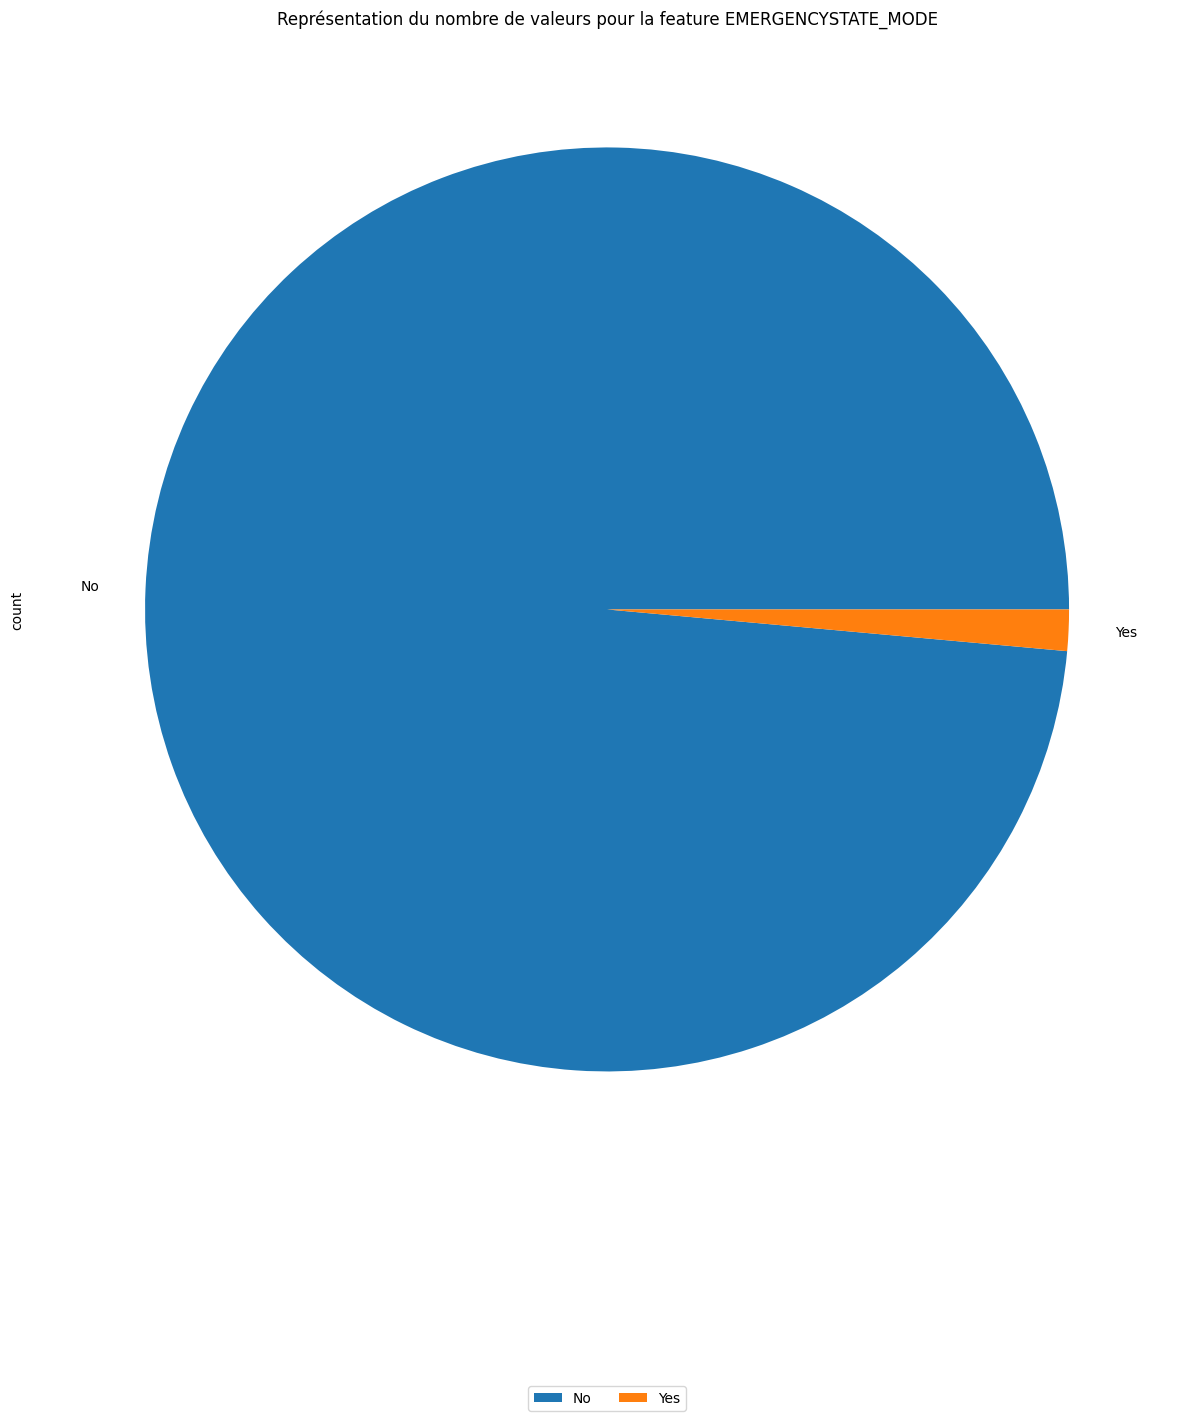

In [83]:
for col in app_train.select_dtypes('object'):
    plt.figure(figsize=(20,15))
    app_train[col].value_counts().plot.pie()
    plt.title(f'Représentation du nombre de valeurs pour la feature {col}')
    plt.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5,-0.2))
    

In [84]:
display_info(title="visualisation de la relation entre Target et nos autres variables",color="green")
display_info(title="Création d'un sous-ensembles positifs et négatifs",color="green",tag="h3")

In [85]:
clientInPain_df=app_train[app_train['TARGET']==1]
clientInPain_df = clientInPain_df.drop('TARGET', axis=1)

In [86]:
clientInGood_df=app_train[app_train['TARGET']==0]
clientInGood_df=clientInGood_df.drop('TARGET', axis=1)

In [103]:
display_info(title="Création d'un sous-ensembles des colonnes AMT",color="green",tag="h3")

In [102]:
amt_df = app_train.filter(like='AMT')

(307511, 10)

In [106]:
display_info(title="Création d'un sous-ensembles des colonnes DAYS",color="green",tag="h3")

In [107]:
day_df = app_train.filter(like='DAYS')

In [87]:
missing_rate=app_train.drop('TARGET', axis=1)
missing_rate = missing_rate.isna().sum()/app_train.shape[0]
missing_rate.sort_values(ascending=False)

EXT_SOURCE_1                    0.563811
NONLIVINGAREA_MEDI              0.551792
NONLIVINGAREA_AVG               0.551792
NONLIVINGAREA_MODE              0.551792
ELEVATORS_MEDI                  0.532960
ELEVATORS_MODE                  0.532960
ELEVATORS_AVG                   0.532960
WALLSMATERIAL_MODE              0.508408
APARTMENTS_MODE                 0.507497
APARTMENTS_AVG                  0.507497
APARTMENTS_MEDI                 0.507497
ENTRANCES_MODE                  0.503488
ENTRANCES_MEDI                  0.503488
ENTRANCES_AVG                   0.503488
LIVINGAREA_AVG                  0.501933
LIVINGAREA_MEDI                 0.501933
LIVINGAREA_MODE                 0.501933
HOUSETYPE_MODE                  0.501761
FLOORSMAX_MEDI                  0.497608
FLOORSMAX_MODE                  0.497608
FLOORSMAX_AVG                   0.497608
YEARS_BEGINEXPLUATATION_AVG     0.487810
YEARS_BEGINEXPLUATATION_MODE    0.487810
YEARS_BEGINEXPLUATATION_MEDI    0.487810
TOTALAREA_MODE  

In [88]:
compare_df = app_train.drop('TARGET', axis=1)
compare_df = compare_df.columns[(missing_rate<0.6)]

In [110]:
display_info(title="Visualisation Target / AMT",color="green",tag="h3")

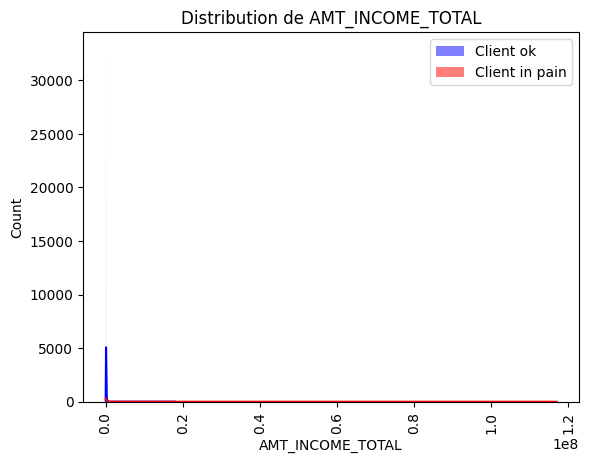

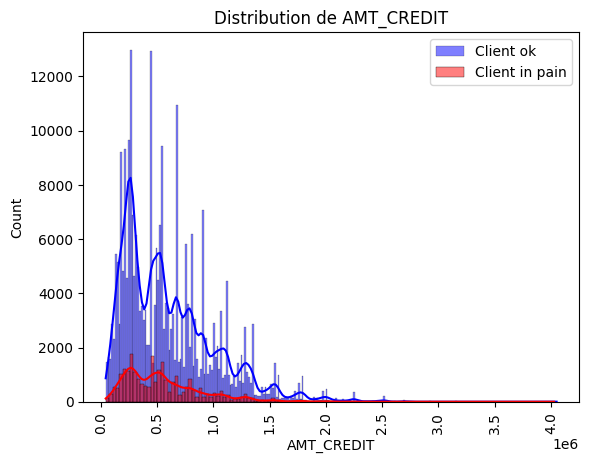

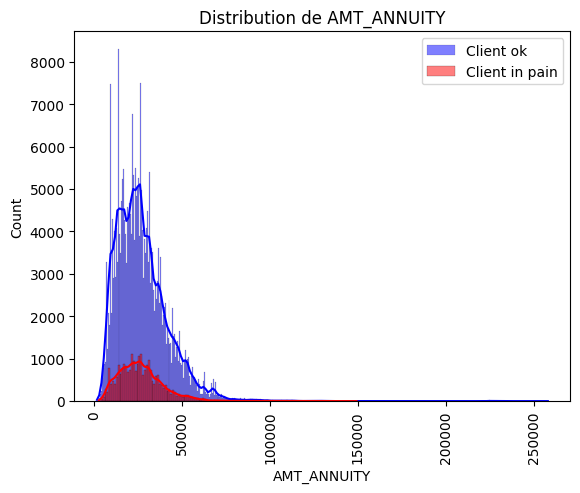

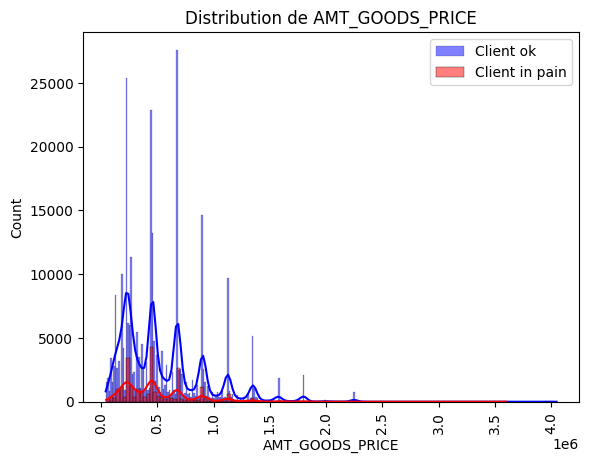

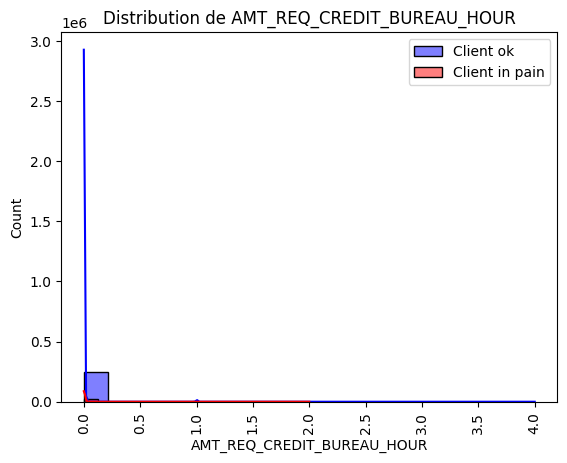

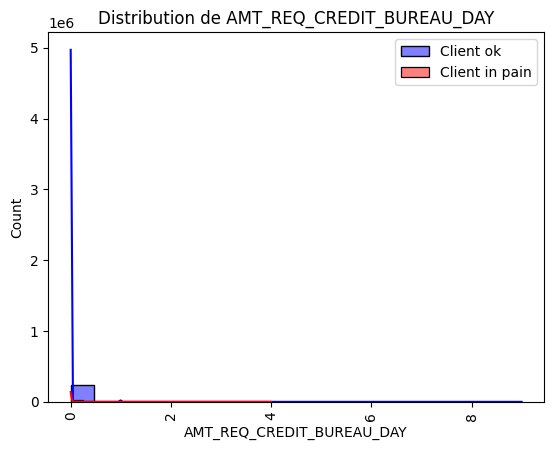

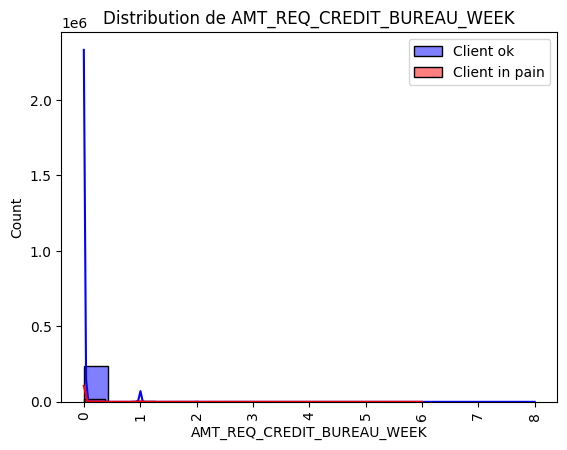

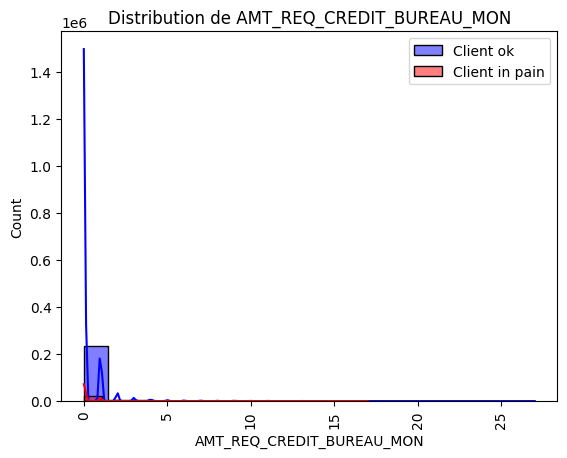

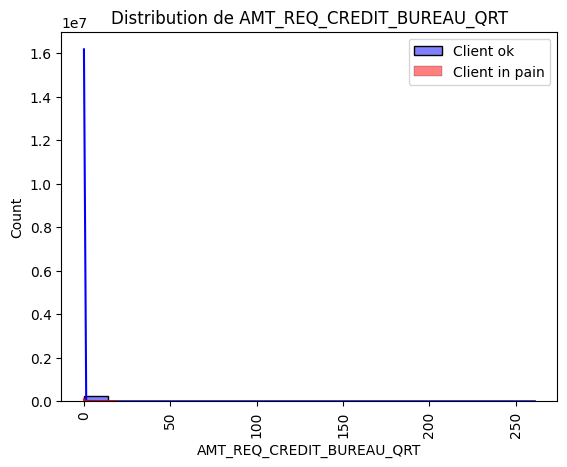

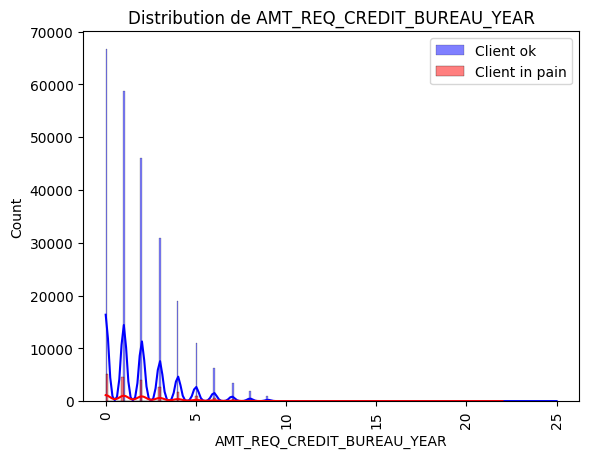

In [109]:
display_info(message="On visualise Variable après variables si il y a un différence entre les clients en difficulté et le client ok")
for col in amt_df:
    plt.figure()
    sns.histplot(clientInGood_df[col],kde=True, label='Client ok',color='blue')
    sns.histplot(clientInPain_df[col],kde=True, label='Client in pain', color='red')
    plt.title(f'Distribution de {col}')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

In [74]:
display_info(message="Il n'y a pas de différence de distribution notable sur nos variables")

In [111]:
display_info(title="Visualisation Target / DAYS",color="green",tag="h3")

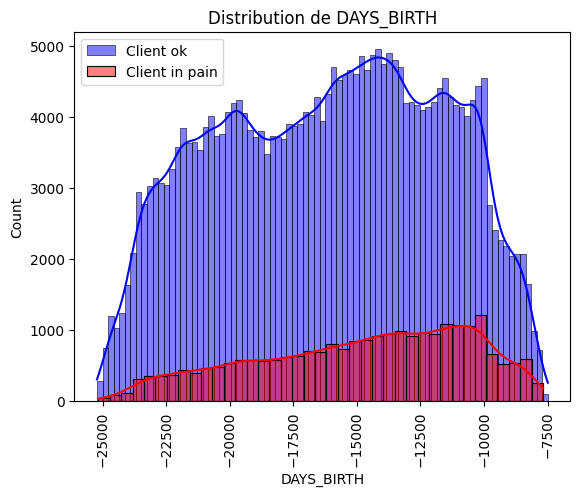

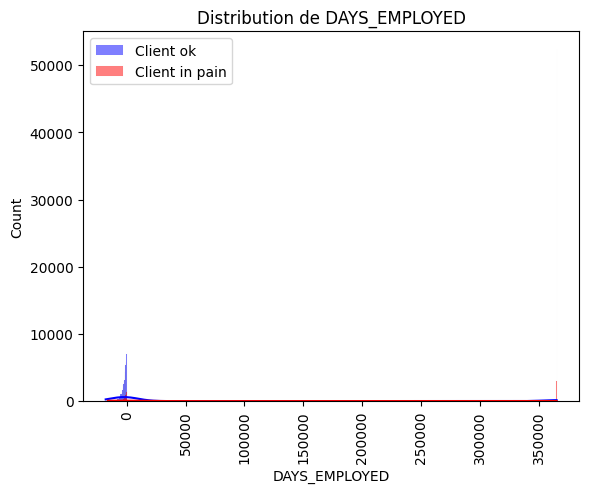

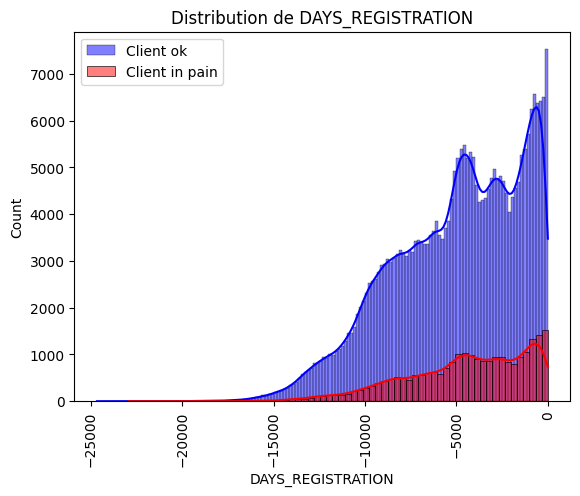

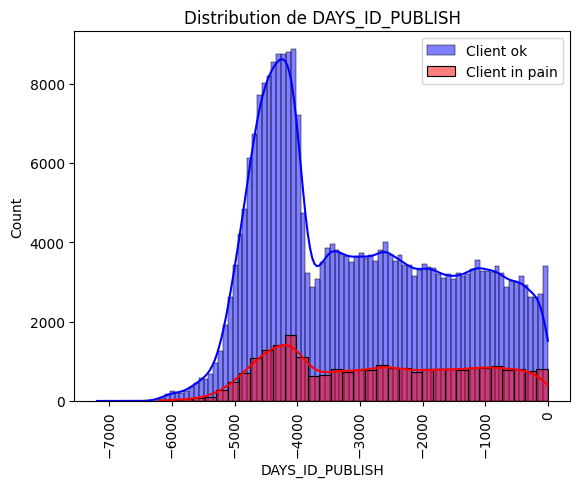

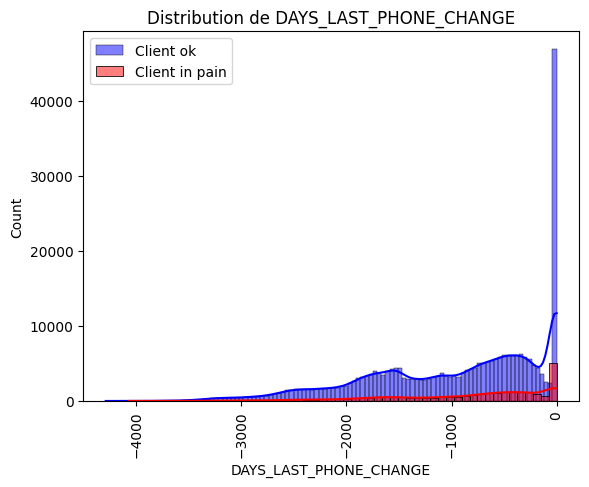

In [117]:
display_info(message="On visualise Variable après variables si il y a un différence entre les clients en difficulté et le client ok")
for col in day_df:
    plt.figure()
    sns.histplot(clientInGood_df[col],kde=True, label='Client ok',color='blue')
    sns.histplot(clientInPain_df[col],kde=True, label='Client in pain', color='red')
    plt.title(f'Distribution de {col}')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

In [118]:
display_info(message="Les distribution semble etre identique et proportionnel au statut du client")

In [131]:
display_info(title="Target / DAYS_BIRTH", color="green",tag="h3")

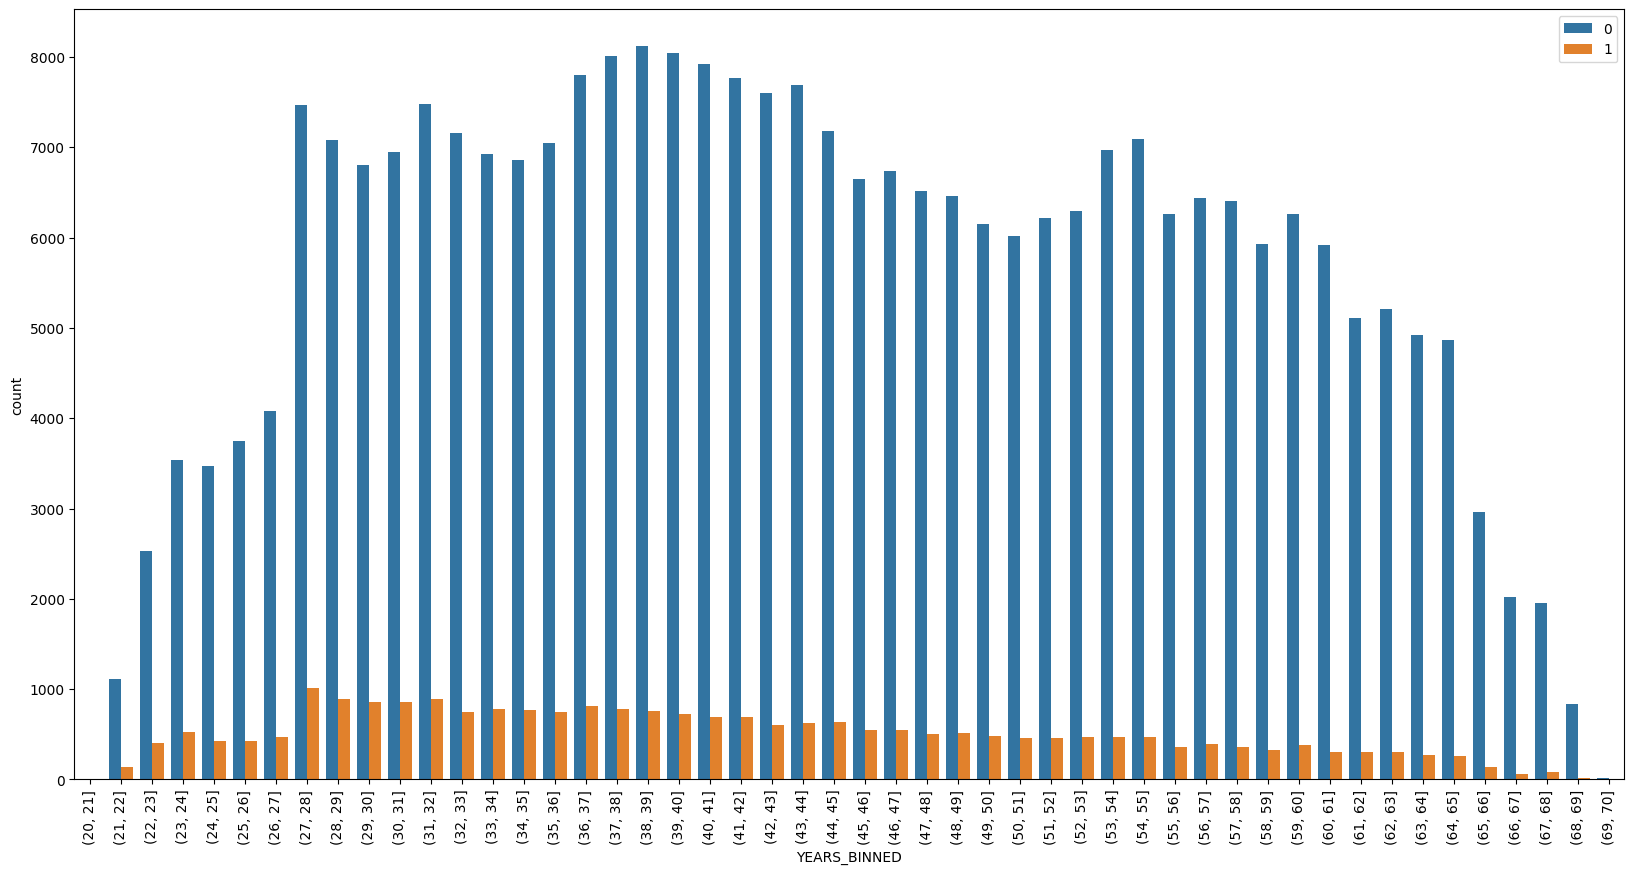

In [115]:
app_train['YEARS_BIRTH'] = app_train['DAYS_BIRTH'] / -365
app_train['YEARS_BINNED'] = pd.cut(app_train['YEARS_BIRTH'], bins=range(20, 71, 1))

plt.figure(figsize=(20,10))
sns.countplot(x='YEARS_BINNED', hue='TARGET', data= app_train)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [116]:
display_info(message="Il n'y a pas de différence de distribution notable de notre target en fonction de l'age des clients")

In [99]:
display_info(title="Conclusions initiales",color="yellow")
display_info(message="""<ul>
             <li>Beaucoup de données manquantes</li>
             <li>La TARGET est desiquilibré  10% de client en difficulté pour 90% de client SANS difficulté </li>
             <li>Pas de différence notable de distribution entre les valeurs de la TARGET</li>
             </ul>
             """)

In [133]:
display_info(title="Analyse multivariées", color="yellow")
display_info(title="Relation AMT/AMT", color="green")


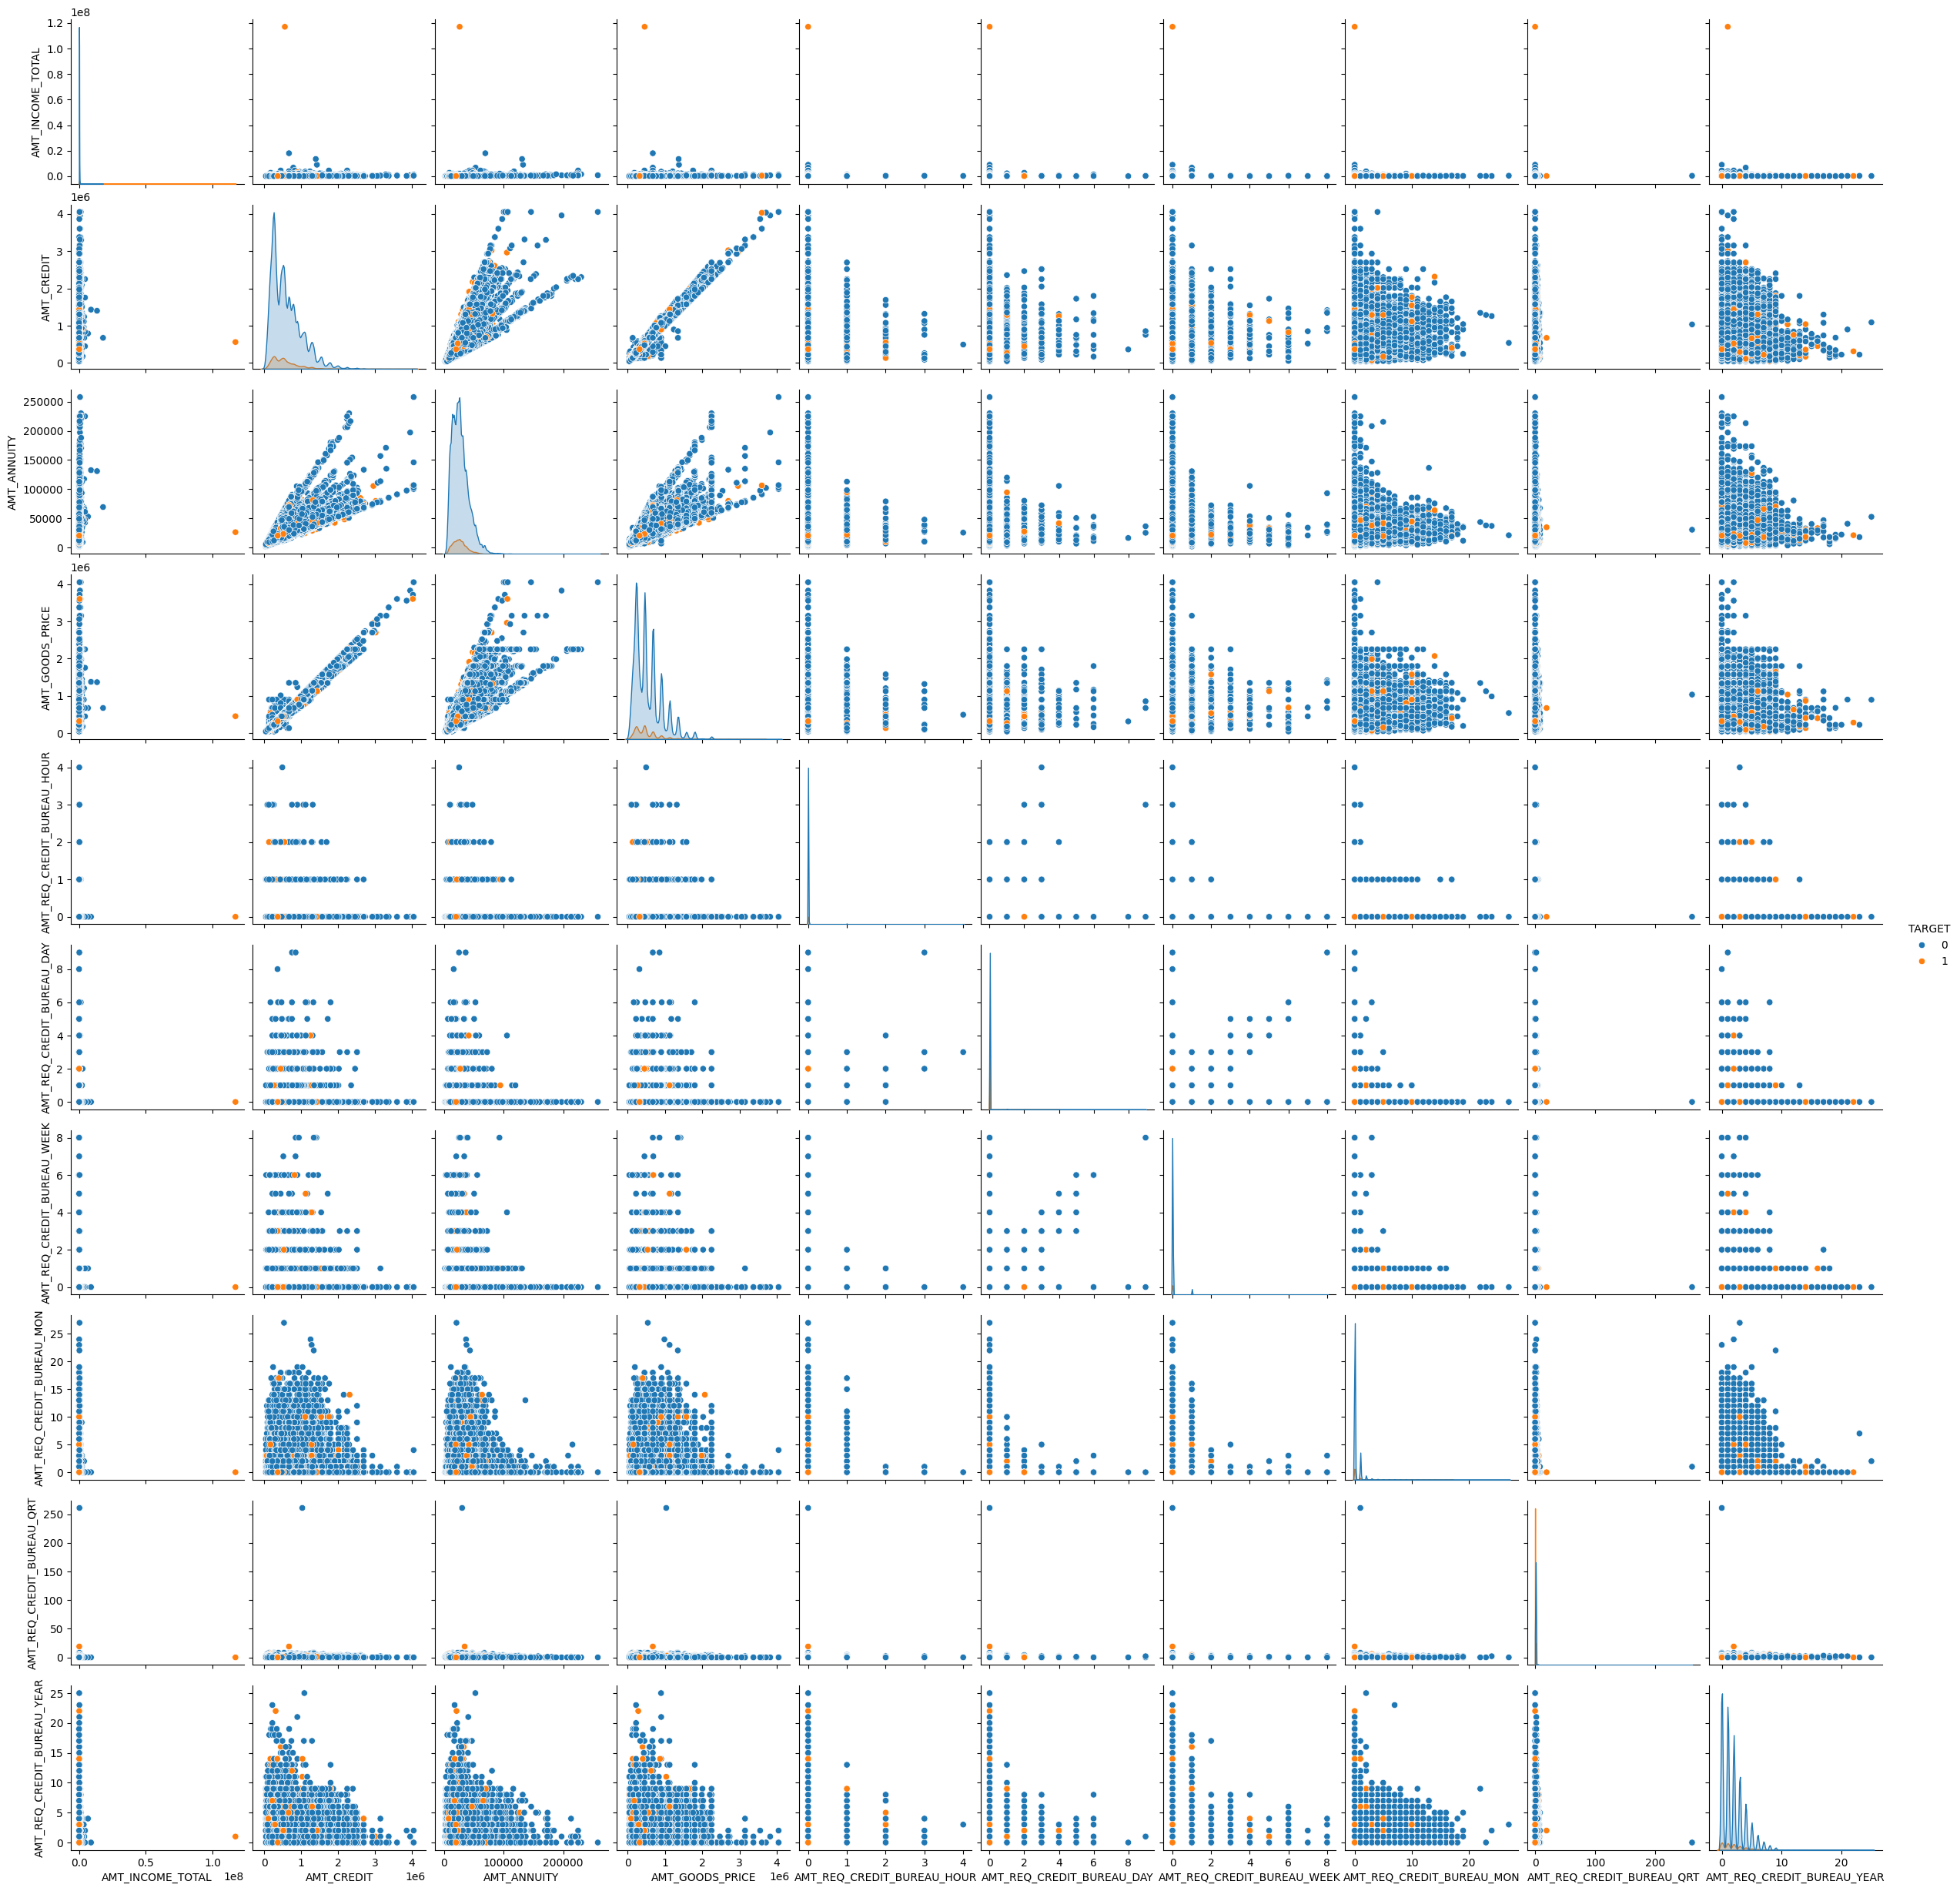

In [139]:
amt_cols = list(amt_df.columns) + ['TARGET']
sns.pairplot(app_train[amt_cols],hue='TARGET')

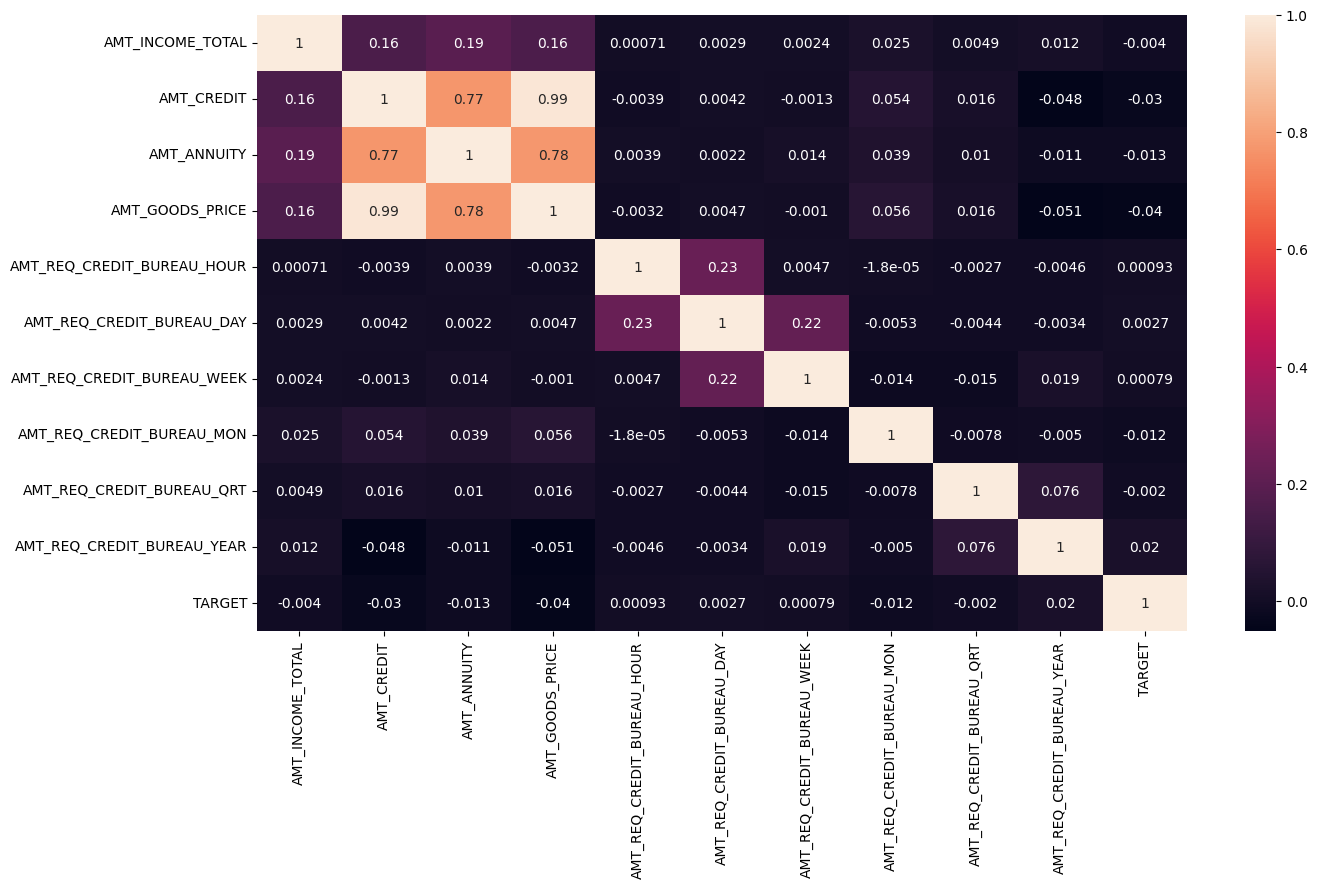

In [144]:
plt.figure(figsize=(15,8))
sns.heatmap(app_train[amt_cols].corr(), annot=True)
plt.show()

In [222]:
display_info(title="Les clients en difficulté de paiement sont largement sous-représentés (8.1%) dans les données d'entraînement",color="green",fontsize="24px")
display_info(message="Il s'agit d'un déséquilibre de classe.")
display_info(message=
             "Les méthodes de machine learning classiques ne sont pas toujours adaptées pour la classification sur des données déséquilibrées. Elles donnent souvent de mauvais résultats et, pire encore, elles peuvent induire en erreur avec des scores trop optimistes.</br>Une des causes de ces échecs est que les points de la classe minoritaire sont considérés comme des outliers qui ne contiennent aucune information.")
display_info(title="Les différentes méthodes pour pallier le déséquilibre des classes", color="green",fontsize="24px")
display_info(message="On sépare les approches pour contourner le déséquilibre des classes en 2. </br>Les méthodes data-level qui consistent en des transformations opérées sur les données d’entraînement, et les méthodes algorithm-level qui reposent sur des modifications des modèles utilisés pour qu’ils soient plus adaptés à ce problème.")
display_info(title="1. Méthodes data-level", color="yellow")
display_info(message="L’idée derrière les approches data level est toujours la même. Il s’agit de transformer les données d’entraînement du modèle pour atténuer le déséquilibre. On va souvent utiliser des techniques d’échantillonnage pour ajouter des représentants dans la classe minoritaire et/ou en retirer de la classe majoritaire.")
display_info(pTag="ul",message="Sous-échantillonnage aléatoire:</br></br><li>La première approche consiste en un sous-échantillonnage de la classe majoritaire. On cherche à réduire la taille de la classe majoritaire pour atténuer le déséquilibre des classes. On va choisir les points à retirer de manière très naïve, simplement en retirant des points de façon aléatoire.</li>")
display_info(pTag="ul",message="Tomek links:</br></br><li>Une autre approche de sous-échantillonnage de la classe majoritaire, un peu plus fine cette fois, propose un moyen plus naturel pour choisir les points à éliminer. L’idée est de chercher ceux de la classe majoritaire qui sont assez proches d’un point de la classe minoritaire. Les paires de points identifiées sont appelées tomek links. Dans chaque tomek link on va retirer le point qui appartient à la classe majoritaire.</li></br></br><li>Cette approche sera en pratique plus efficace que le sous-échantillonnage aléatoire. Elle va réduire la variance de la classe majoritaire et supprimer d’éventuels outliers, qui peuvent être une grande source de confusion.</li>")
display_info(pTag="ul",message=
             """SMOTE:</br></br><li>L’autre approche d’échantillonnage que l’on retrouve souvent est SMOTE (Synthetic Minority Oversampling Technic). C’est une technique de sur-échantillonnage cette fois. Plutôt que de réduire la taille de la classe majoritaire, on cherche à agrandir celle de la classe minoritaire.</li>
             </br></br>
             <li>Pour cela, on va sélectionner des points de la classe que l’on souhaite agrandir et en créer de nouveaux. C’est une méthode très semblable à la data augmentation que l’on utilise pour réduire les risques d’overfitting.</li>""")
display_info(title="2. Méthodes algorithm-level", color="yellow")
display_info(message="La deuxième grande famille d’approches regroupe les méthodes dites algorithm-level. Elles reposent sur des adaptations des modèles de machine learning classiques afin qu’ils soient en mesure de mieux gérer le déséquilibre.")
display_info(pTag="ul",message=
             """Apprentissage sensible aux coûts:</br></br>
             <li>Une des méthodes algorithm-level possible, est celle qui consiste à affecter un poids plus important à la classe minoritaire. On parle d’apprentissage sensible aux coûts. En pratique on va spécifier à notre modèle que le fait de bien classer un point de la classe minoritaire est plus important que de bien classer un point de la classe majoritaire. De cette façon on s’arrange pour qu’une erreur de classification d’un point de la classe minoritaire soit considérée par le modèle comme étant plus grave qu’une erreur de classification sur la classe majoritaire.</br></br>
             Comme l’objectif des modèles de machine learning est toujours d’optimiser un paramètre prédéfini, on observe que l’optimisation du gain va inciter l’algorithme à donner plus d’importance à la classe minoritaire et donc à améliorer les prédictions sur celle-ci.</br></br>
             Dans l’implémentation Scikit-learn de random forest on peut jouer avec la classe sample_weights. Et d’après une discussion sur Stack, il semblerait que ce paramètre repose sur la technique d’apprentissage sensible aux coûts. Random forest, lors du calcul des probabilités d’appartenance d’un point à une classe, redistribue ces probabilités en tenant compte des ratios spécifiés.</li>
             </br></br>""")
display_info(pTag="ul",message=
             """Apprentissage à une classe:</br></br>
             <li>Une autre approche qui pourrait donner de bons résultats dans certains cas est l’apprentissage à une classe. Plutôt que d’entraîner un classifieur sur nos 2 classes, on entraîne un détecteur sur la classe majoritaire. Il sera ensuite capable de prédire si un point fait partie de la classe ou non. Même si les modèles d’apprentissage à une classe ne sont pas spécialement conçus pour contrer le déséquilibre des classes, ils peuvent offrir de gros gains de performances.</li></br></br>""")
display_info(title="3. Bien choisir les métriques pour mesurer les performances des modèles", color="yellow")
display_info(message=
             """Généralement en machine learning, il faut s’attarder sur le choix des métriques de mesure des performances. Cette règle est encore plus fondamentale lorsque l’on travaille sur des données déséquilibrées. Même si ça ne nous permet pas de contrer le problème, bien choisir les métriques nous permettra d’éviter des déconvenues.</br></br>
             Par exemple, en classification binaire il est d’usage d’utiliser le pourcentage de bonnes prédictions comme score. Sauf que ce pourcentage peut être élevé même si une grande partie des points de la classe minoritaire sont mal classifiés. Le score va lui aussi être affecté par le déséquilibre des classes. On pourrait croire que notre modèle est bon même lorsqu’il n’est bon que pour la classe majoritaire.

Pour pallier ce problème, nous allons nous tourner vers des métriques qui ne seront pas affectées par la mauvaise répartition. On peut par exemple tracer la matrice de confusion du modèle</br></br>
On pourra aussi utiliser des métriques qui seront beaucoup moins influencées par la classe majoritaire. Le recall (sensibilité) ou le F-Score sont de bons exemples.""")

In [34]:
display_info(title='Metrics', color="yellow",fontsize="36px")
display_info(message="""Notre objectif est de minimiser les Faux négatif car FN = 10FP.</br></br>
             Il faut donc limiter les mauvais client prédit bon client.</br></br>
             Cette metric est appelé Recall""",fontsize="16px")
display_info(fontsize="16px",message="""On utilisera aussi le F1-score qui est une métrique de classification qui mesure la capacité d’un modèle à bien prédire les individus positifs,
             tant en termes de precision (taux de prédictions positives correctes) qu’en termes de recall (taux de positifs correctement prédits).</br></br>
              Il correspond en effet à la moyenne harmonique de ces indicateurs, qui doivent tous deux être élevés pour que le F1-score le soit aussi. """)


## Data Cleaning ensembles d'entraînement

/var/folders/gk/r5q0c38n70s02t1z45pl1x400000gp/T/ipykernel_82882/233768322.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(percentage.index,rotation=90, fontsize=8)


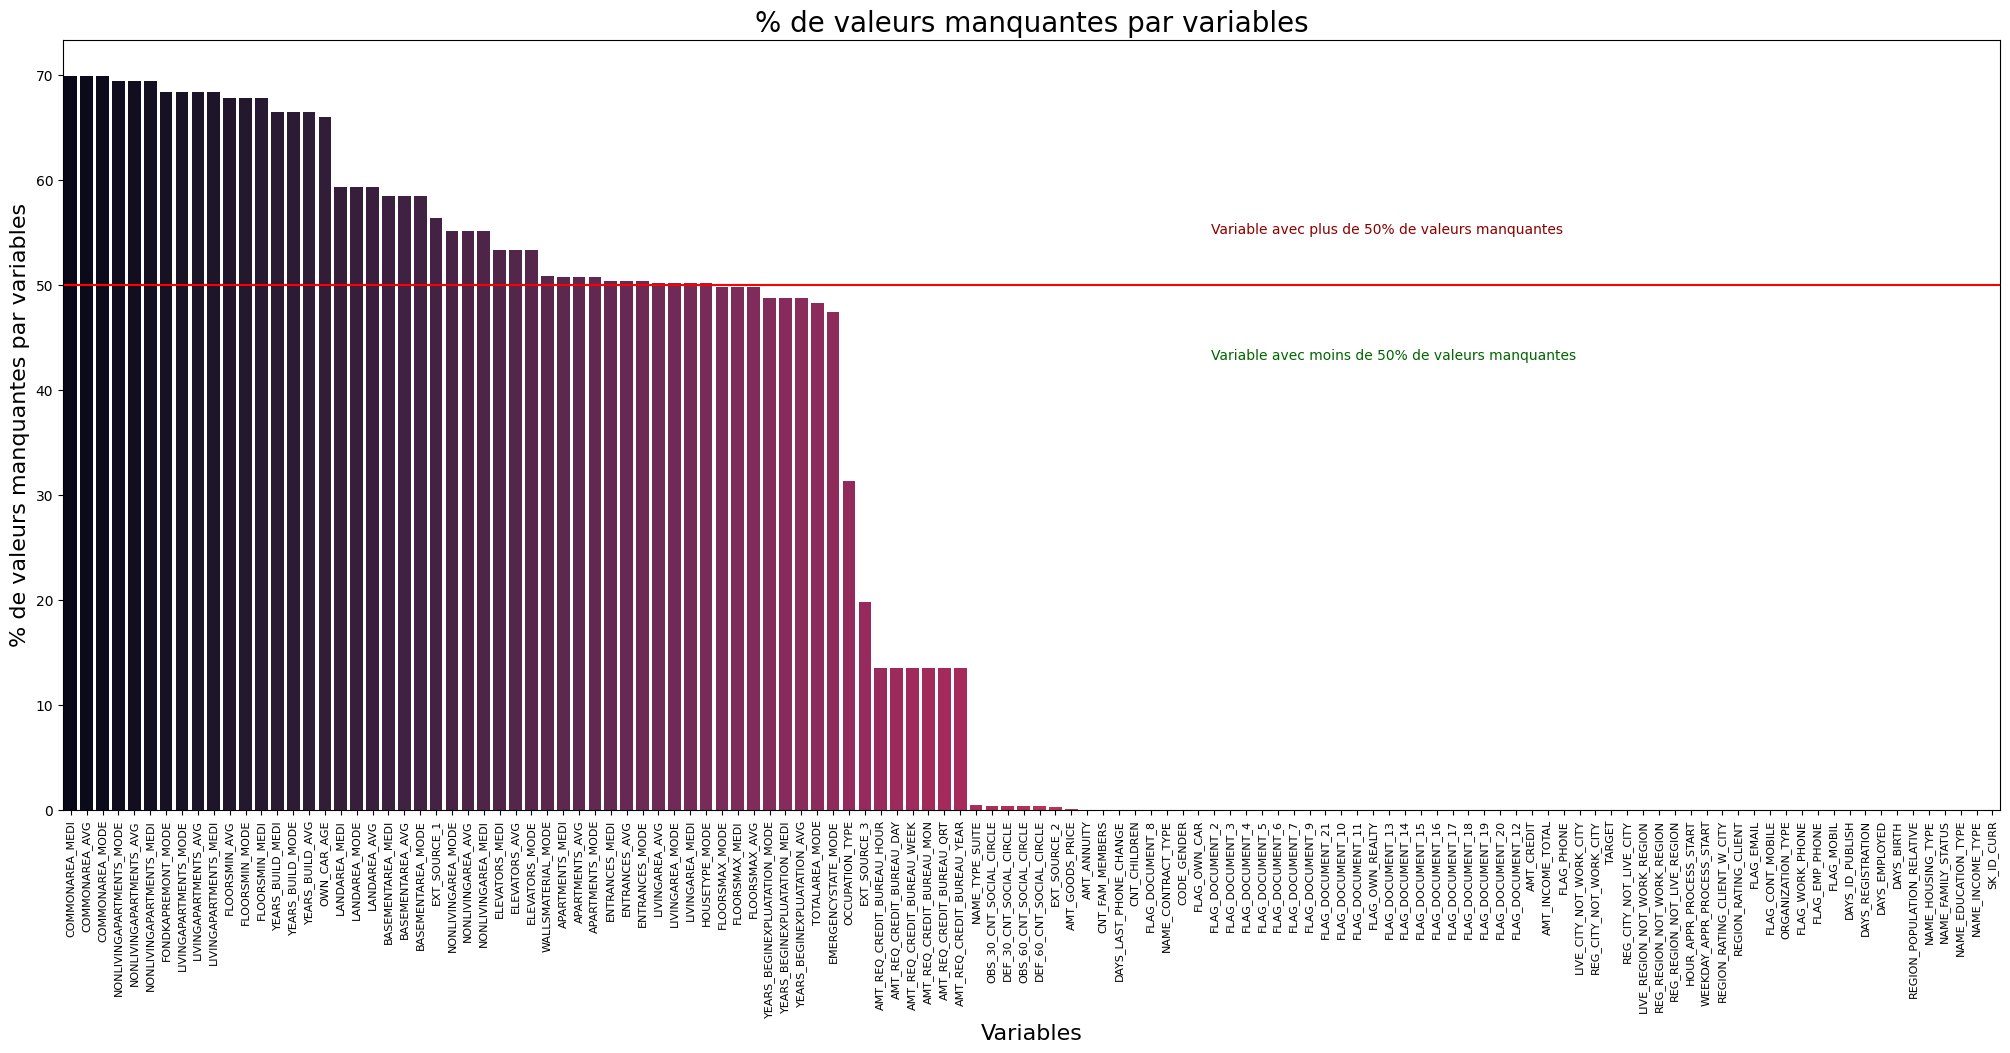

In [11]:
app_train_missingNum = app_train.select_dtypes(include=['int','float64'])

treshold_null = 50
fig,ax = plt.subplots(1,1,figsize=(25,10))
percentage = (app_train.isnull().sum()*100)/app_train.shape[0]
percentage=percentage.sort_values(ascending=False)

ax = sns.barplot(x=app_train.columns, y=percentage,palette="rocket", ax=ax, hue=app_train.columns)

plt.axhline(y=treshold_null,color='r', linestyle ='-')

plt.text(len(app_train.isnull().sum()/len(app_train))/1.7,treshold_null+6,f"Variable avec plus de {treshold_null}% de valeurs manquantes", ha='left',va='top', color='darkred')
plt.text(len(app_train.isnull().sum()/len(app_train))/1.7,treshold_null-6,f"Variable avec moins de {treshold_null}% de valeurs manquantes", ha='left',va='top', color='darkgreen')

ax.set_title("% de valeurs manquantes par variables",fontsize=20)
ax.set_ylabel("% de valeurs manquantes par variables", fontsize=16)
ax.set_xlabel("Variables",fontsize=16)
ax.set_xticklabels(percentage.index,rotation=90, fontsize=8)
plt.show()

In [12]:
app_train_missingNum.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868  -16036.995067   63815.045904  ...   
std                      0.013831    4363.988632  141275.766519  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -2760.000000  ...   
50%                      0.018850  -15750.000000   -1213.000000  ...   
75%                      0.028663  -12413.000000    -289.000000  ...   
max                      0.072508   -7489.000000  365243.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                    0.000000  
25%              

**Le describe nous permet d'avoir une vue rapide des valeurs de chaque variable**</br>
</br>
On remarque que <b>DAYS_EMPLOYED</b> contient des valeurs impossibles. Les valeurs sont relative à la date de l'application. Il ne peut donc pas y avoir de valeur positive.

In [13]:
negative_count=app_train_missingNum[app_train_missingNum["DAYS_EMPLOYED"] <= 0]["DAYS_EMPLOYED"].value_counts().sum()
negative_count

np.int64(252137)

In [14]:
positive_count=app_train_missingNum[app_train_missingNum["DAYS_EMPLOYED"] > 0]["DAYS_EMPLOYED"].value_counts().sum()
positive_count

np.int64(55374)

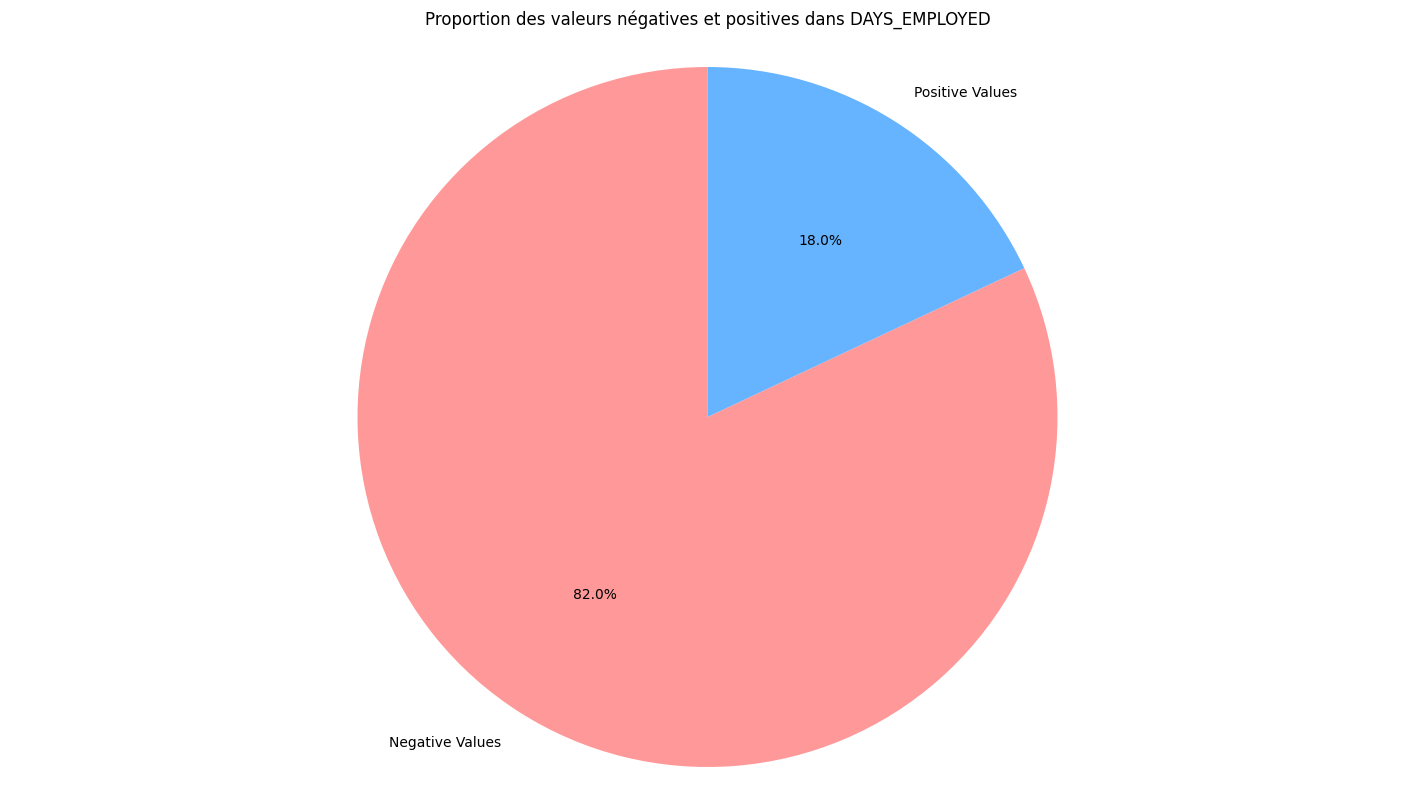

In [15]:
labels = ['Negative Values','Positive Values']
sizes = [negative_count,positive_count]

colors =['#ff9999','#66b3ff']

fig,ax=plt.subplots(figsize=(18,10))

ax.pie(sizes,labels=labels, colors=colors,autopct='%1.1f%%', startangle=90)
ax.axis('equal')

plt.title('Proportion des valeurs négatives et positives dans DAYS_EMPLOYED')

plt.show()

In [16]:
colsRelative_time = ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_CREDIT',
                     'DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','DAYS_CREDIT_UPDATE','MONTHS_BALANCE','DAYS_DECISION','DAYS_FIRST_DRAWING','DAYS_FIRST_DUE',
                     'DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION','DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT']

In [17]:
def out_of_relative_time_data(data):
    data_filtered=data.copy()
    for col in colsRelative_time:
        if col in data.columns:
            data_filtered=data_filtered[data_filtered[col]<=0]
    return data_filtered


In [18]:
usecols_app = ['SK_ID_CURR','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_BIRTH','DAYS_EMPLOYED','OWN_CAR_AGE','CNT_FAM_MEMBERS','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

In [19]:
app_train=out_of_relative_time_data(app_train)
bureau=out_of_relative_time_data(bureau)
bureau_balance=out_of_relative_time_data(bureau_balance)

In [20]:
merge_1_appTrain_with_bureu = pd.merge(app_train[usecols_app],bureau,on='SK_ID_CURR', how='left')
merge_1=merge_1_appTrain_with_bureu
merge_1.shape

(717219, 28)

In [21]:
merge_2_merge1_with_bureauBalance=pd.merge(merge_1,bureau_balance,on='SK_ID_BUREAU', how='left')
merge_2 = merge_2_merge1_with_bureauBalance
merge_2.shape

(8527177, 30)